# **Objective**

Objective: Apply data science to help a major bank in Taiwan to predict the likehihood of credit card customers defaulting on their payments.
1. Explore the best models to predict default accounts
2. Identify key characteristics that lead to high defaulting risk
3. Provide insights to banks that can aid new credit approvals and credit limit setting

The goal of this project is to help a major bank in Taiwan to predict the likelihood of a credit card customer defaulting on their credit card balance. Specifically, we want to find the most accurate model(s) that can predict potential customer default accounts based on previous data about customers' socialeconomic status, credits, and recent transactions. We also aim to identify key characteristics that may lead to higher risks of defaulting among credit card customers. Overall, we hope that this analysis will provide insights for banks, especially those in Taiwan, to aid their new credit approvals and setting more appropriate credit limits to minimize defaulting.

In this work, the [dataset](https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients) we are using consists of credit card clients' default cases, as well as payment data from April to September, 2005 provided by a prominent bank in Taiwan. It contains a total of 23 features and 30,000 instances.



# **Part 1: Data Loading and Summarization**

**Import:** Load necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

**Load Dataset:** Load the credit card default dataset into a Pandas dataframe

In [2]:
df = pd.read_csv("default_of_credit_card_clients.csv")

In [ ]:
df.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


**Variable Description**


*   X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
*  X2: Gender (1 = male; 2 = female).
*  X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).

*  X4: Marital status (1 = married; 2 = single; 3 = others).
*  X5: Age (year)
*  X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
*  X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
*  X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.














# **Part 2: Data Cleaning and Transformations**

1. Check for any missing values

In [ ]:
df.isna().sum()

,0
Unnamed: 0,0
X1,0
X2,0
X3,0
X4,0
X5,0
X6,0
X7,0
X8,0
X9,0


The above result indicates that there's no missing values in this dataset.

2. Replace the column names with the first row of the dataset. Also, dropping the ID column because we already have the row index.

In [3]:
df.columns = df.iloc[0].values
df = df.iloc[1:]

In [4]:
df = df.rename(columns={'default payment next month':'default'})

In [5]:
df = df.drop('ID', axis=1)

Rename the column 'Pay_0' to 'Pay_1'.

In [6]:
df = df.rename(columns={'PAY_0': 'PAY_1'})

3. Transform all feature variables, including categorical variables, into integer values because some models such as XGBoost doesn't support categorical data types. Since the categorical variables EDUCATION, MARRIAGE, SEX, PAY_0, PYA_1, PAY_2, PAY_3, PAY_4,and PAY_5 are already encoded into numbers, we can directly convert the data types of these columns into integers.

In [7]:
# split data into X and y variables
X = df.drop('default', axis=1)
y = df['default']

In [8]:
# convert all independent variables to integer data type
for col in X.columns:
    X[col] = X[col].astype(int)

# **Part 3. Feature Engineering**

1. Assuming the frequency of a category of categorical features is a relevant predictor, we will apply frequency encoding to categorical variables (EDUCATION, MARRIAGE, PAY_1 to PAY_6) based on how often the category appears in the dataset. This creates 8 new features to the dataset.

In [9]:
for col in ['EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
       freq_mapping = X[col].value_counts(normalize=True).to_dict()
       X[col + '_freq_encoded'] = X[col].map(freq_mapping)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 1 to 30000
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   LIMIT_BAL               30000 non-null  int64  
 1   SEX                     30000 non-null  int64  
 2   EDUCATION               30000 non-null  int64  
 3   MARRIAGE                30000 non-null  int64  
 4   AGE                     30000 non-null  int64  
 5   PAY_1                   30000 non-null  int64  
 6   PAY_2                   30000 non-null  int64  
 7   PAY_3                   30000 non-null  int64  
 8   PAY_4                   30000 non-null  int64  
 9   PAY_5                   30000 non-null  int64  
 10  PAY_6                   30000 non-null  int64  
 11  BILL_AMT1               30000 non-null  int64  
 12  BILL_AMT2               30000 non-null  int64  
 13  BILL_AMT3               30000 non-null  int64  
 14  BILL_AMT4               30000 non-null

In [ ]:
X.iloc[:10,23:30]

,EDUCATION_freq_encoded,MARRIAGE_freq_encoded,PAY_1_freq_encoded,PAY_2_freq_encoded,PAY_3_freq_encoded,PAY_4_freq_encoded,PAY_5_freq_encoded
1,0.467667,0.455300,0.088900,0.130900,0.197933,0.189567,0.151533
2,0.467667,0.532133,0.189533,0.130900,0.525467,0.548500,0.564900
3,0.467667,0.532133,0.491233,0.524333,0.525467,0.548500,0.564900
4,0.467667,0.455300,0.491233,0.524333,0.525467,0.548500,0.564900
5,0.467667,0.455300,0.189533,0.524333,0.197933,0.548500,0.564900
6,0.352833,0.532133,0.491233,0.524333,0.525467,0.548500,0.564900
7,0.352833,0.532133,0.491233,0.524333,0.525467,0.548500,0.564900
8,0.467667,0.532133,0.491233,0.201667,0.197933,0.548500,0.564900
9,0.163900,0.455300,0.491233,0.524333,0.127300,0.548500,0.564900
10,0.163900,0.532133,0.091967,0.126067,0.136167,0.144933,0.184633


2. Assuming bill amount and credit limit has a linear relationship, we will create a new feature "Bill_Amt_Ratio" for each month. This new variable represents the monthly bill amount as a percentage of the credit limit.

In [10]:
for i in range(1,7):
    X['Bill_Amt_Ratio_' + str(i)] = (X['BILL_AMT' + str(i)] / X['LIMIT_BAL']) * 100

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 1 to 30000
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   LIMIT_BAL               30000 non-null  int64  
 1   SEX                     30000 non-null  int64  
 2   EDUCATION               30000 non-null  int64  
 3   MARRIAGE                30000 non-null  int64  
 4   AGE                     30000 non-null  int64  
 5   PAY_1                   30000 non-null  int64  
 6   PAY_2                   30000 non-null  int64  
 7   PAY_3                   30000 non-null  int64  
 8   PAY_4                   30000 non-null  int64  
 9   PAY_5                   30000 non-null  int64  
 10  PAY_6                   30000 non-null  int64  
 11  BILL_AMT1               30000 non-null  int64  
 12  BILL_AMT2               30000 non-null  int64  
 13  BILL_AMT3               30000 non-null  int64  
 14  BILL_AMT4               30000 non-null

In [ ]:
X.iloc[:10,31:36]

,Bill_Amt_Ratio_1,Bill_Amt_Ratio_2,Bill_Amt_Ratio_3,Bill_Amt_Ratio_4,Bill_Amt_Ratio_5
1,19.565000,15.510000,3.445000,0.000000,0.000000
2,2.235000,1.437500,2.235000,2.726667,2.879167
3,32.487778,15.585556,15.065556,15.923333,16.608889
4,93.980000,96.466000,98.582000,56.628000,57.918000
5,17.234000,11.340000,71.670000,41.880000,38.292000
6,128.800000,114.138000,115.216000,38.788000,39.238000
7,73.593000,82.404600,89.001400,108.530600,96.600600
8,11.876000,0.380000,0.601000,0.221000,-0.159000
9,8.060714,10.068571,8.648571,8.722143,8.423571
10,0.000000,0.000000,0.000000,0.000000,65.035000


3. Create three new features indicating whether a customer has consistently paid late for 2, 3, and 4 months. Since in the Pay columns, positive values indicates that there is payment delay (e.g., 1 means 1 month late, 2 means 2 months late). We can apply logical operations to these payment history variables and build new features that captures the late payment habit.

In [11]:
for i in range(2, 5):
    X[f'Consistently_Late_{i}_Months'] = 0
    for j in range(1, 7 - (i - 1)):
        X[f'Consistently_Late_{i}_Months'] = np.where(
            (X[[f'PAY_{j}', f'PAY_{j+1}', f'PAY_{j+i-1}']] > 0).all(axis=1), 1, X[f'Consistently_Late_{i}_Months']
        )

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 1 to 30000
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   30000 non-null  int64  
 1   SEX                         30000 non-null  int64  
 2   EDUCATION                   30000 non-null  int64  
 3   MARRIAGE                    30000 non-null  int64  
 4   AGE                         30000 non-null  int64  
 5   PAY_1                       30000 non-null  int64  
 6   PAY_2                       30000 non-null  int64  
 7   PAY_3                       30000 non-null  int64  
 8   PAY_4                       30000 non-null  int64  
 9   PAY_5                       30000 non-null  int64  
 10  PAY_6                       30000 non-null  int64  
 11  BILL_AMT1                   30000 non-null  int64  
 12  BILL_AMT2                   30000 non-null  int64  
 13  BILL_AMT3                   300

In [ ]:
X.iloc[10:24, 37:40]

,Consistently_Late_2_Months,Consistently_Late_3_Months,Consistently_Late_4_Months
11,0,0,0
12,0,0,0
13,0,0,0
14,1,1,0
15,0,0,0
16,1,0,0
17,1,1,1
18,0,0,0
19,0,0,0
20,0,0,0


4. Add interaction terms for AGE and other variables to capture the correlation between a customer's age and their education or limit balance.

In [12]:
X['AGE_EDUCATION'] = X['AGE'] * X['EDUCATION']
X['AGE_LIMIT_BAL'] = X['AGE'] * X['LIMIT_BAL']

In [ ]:
X.iloc[:5, 40:42]

,AGE_EDUCATION,AGE_LIMIT_BAL
1,48,480000
2,52,3120000
3,68,3060000
4,74,1850000
5,114,2850000


# **Part 4. Exploratory Data Analysis**

Create a histogram for the target variable that shows the number of customers who defaulted versus no-default.

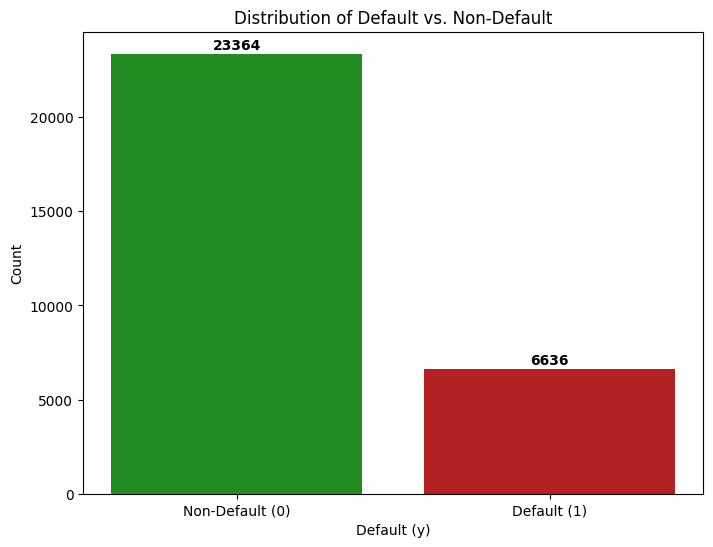

In [ ]:
# Calculate value counts for each class
default_counts = y.value_counts()

# Create the histogram
plt.figure(figsize=(8, 6))
plt.bar(default_counts.index, default_counts.values, color=['forestgreen', 'firebrick'])
plt.xlabel('Default (y)')
plt.ylabel('Count')
plt.title('Distribution of Default vs. Non-Default')

# Annotate each bar with its value
for i, v in enumerate(default_counts.values):
    plt.text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold') # Adjusted vertical position

plt.xticks(default_counts.index, ['Non-Default (0)', 'Default (1)'])
plt.show()

Plot histograms of all original features in the dataset

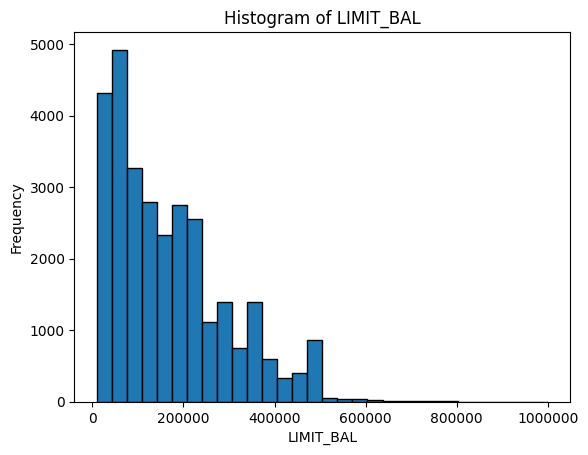

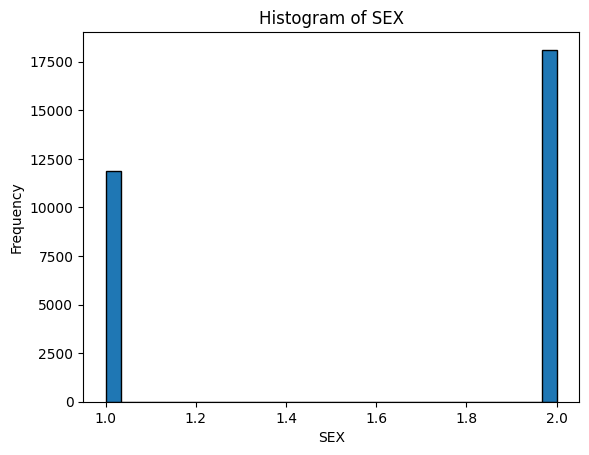

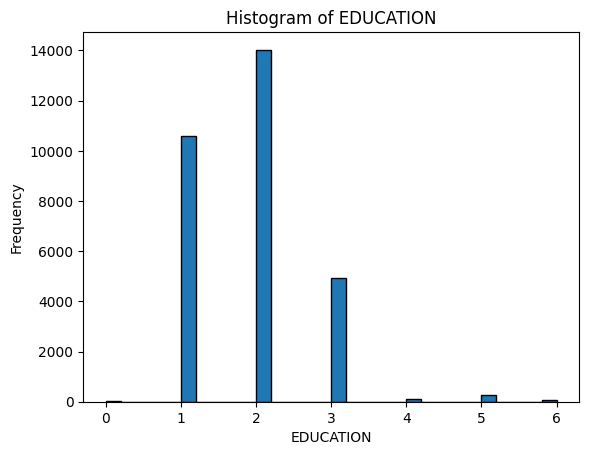

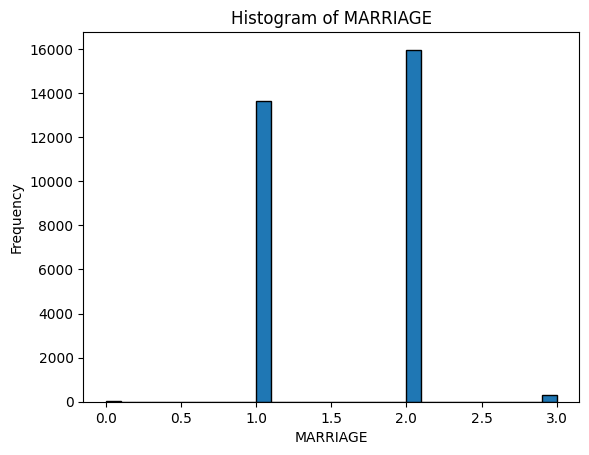

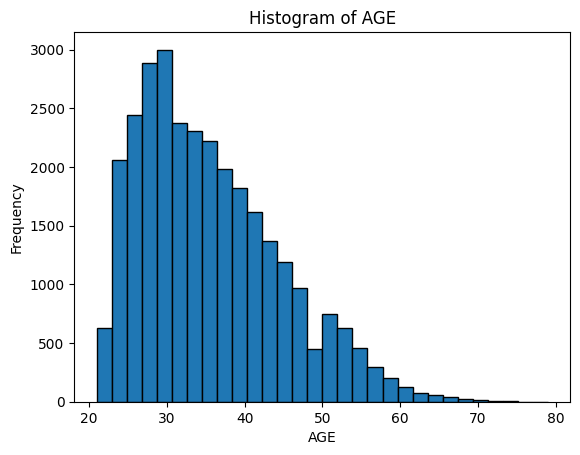

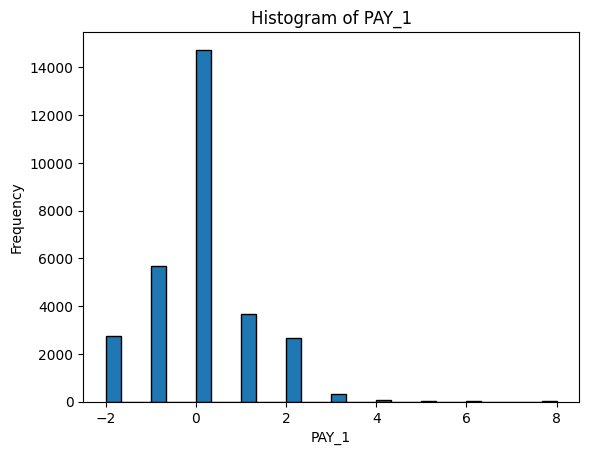

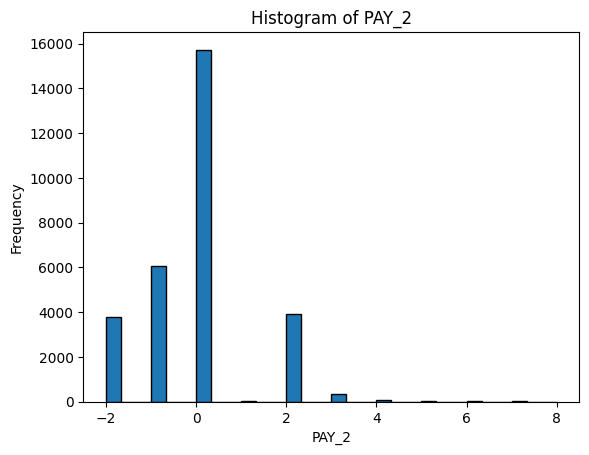

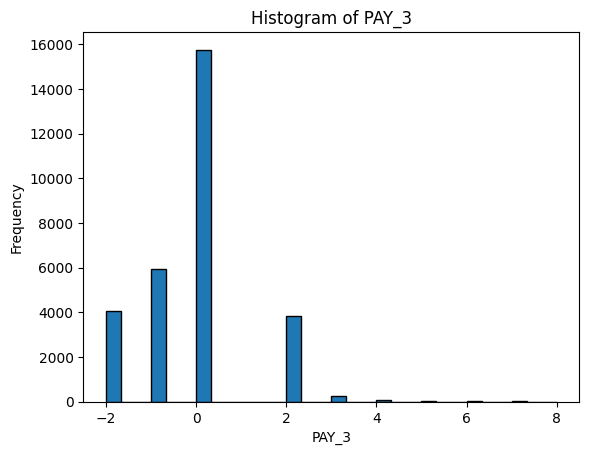

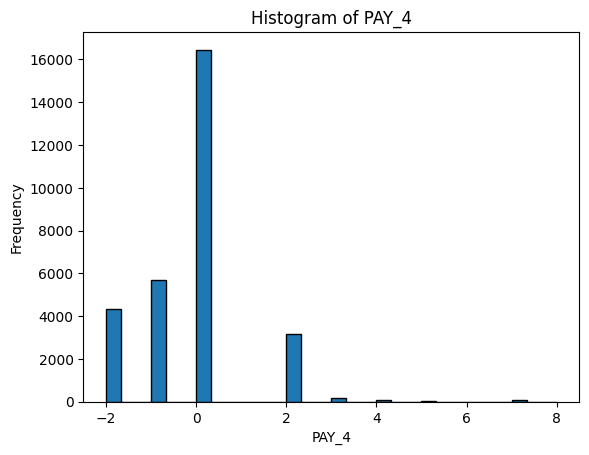

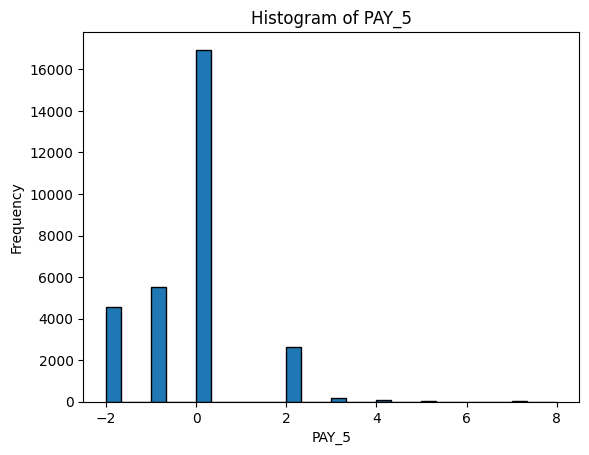

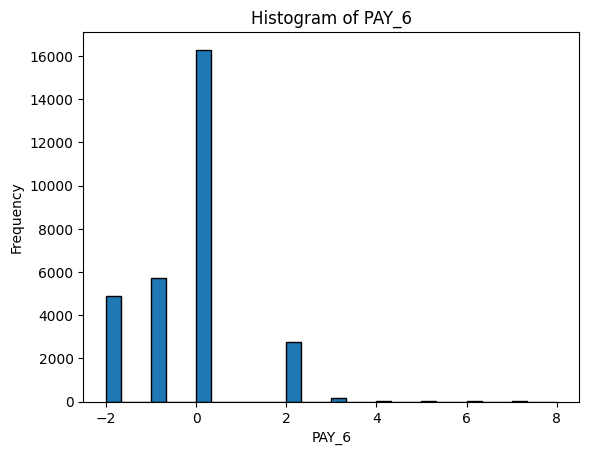

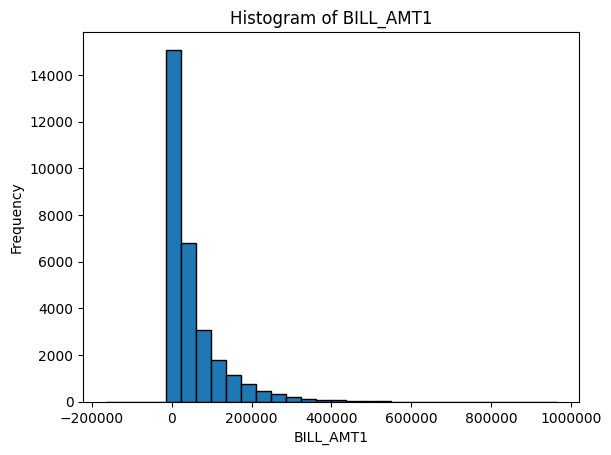

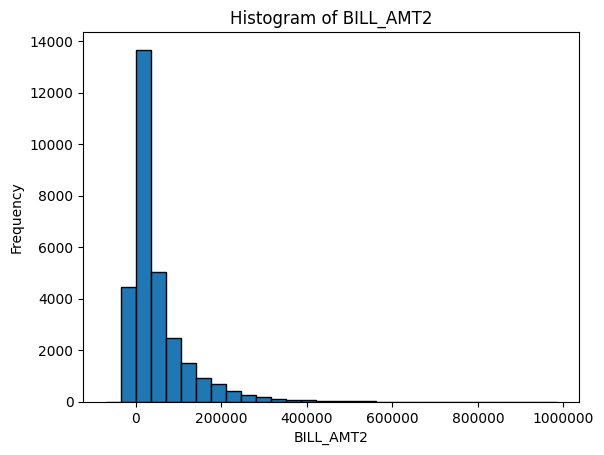

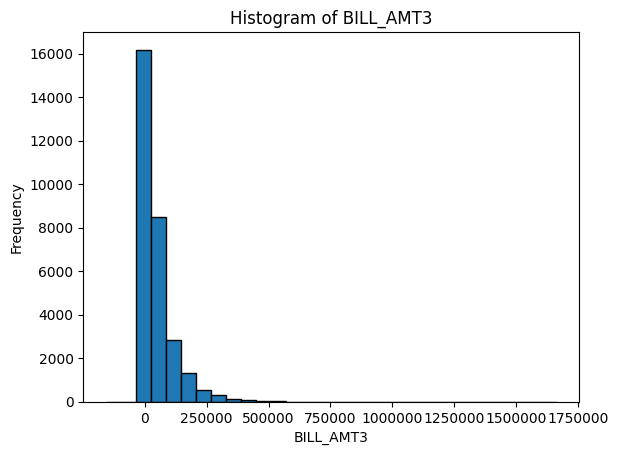

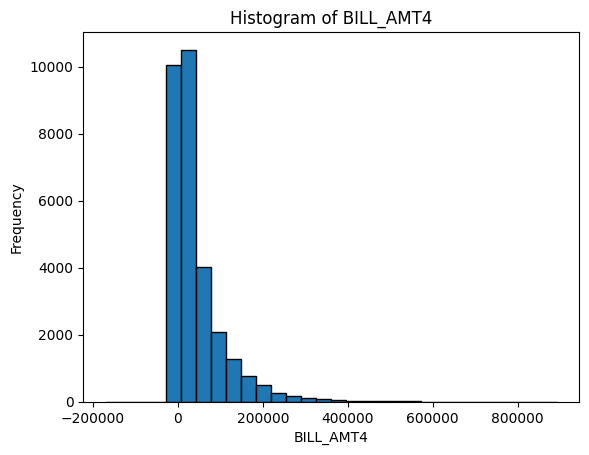

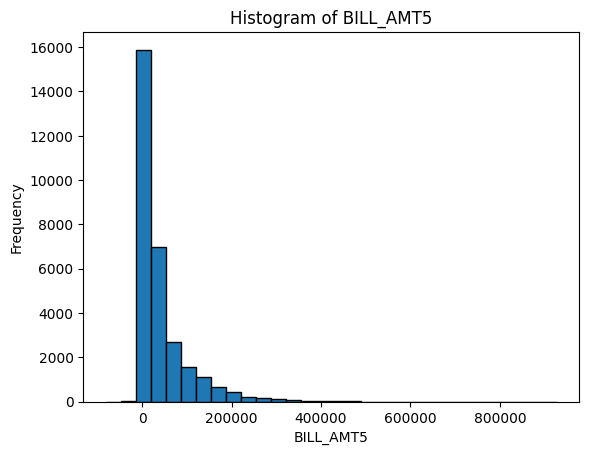

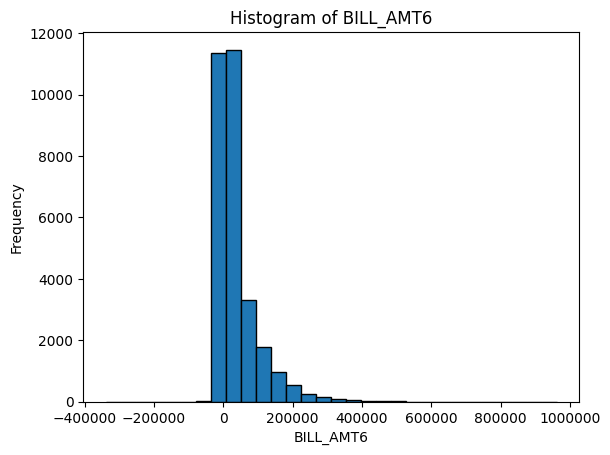

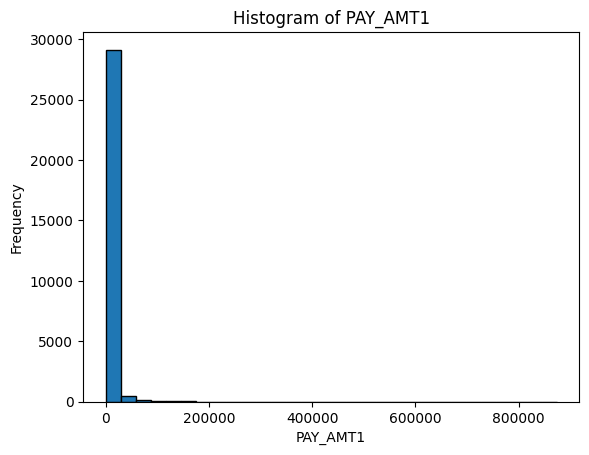

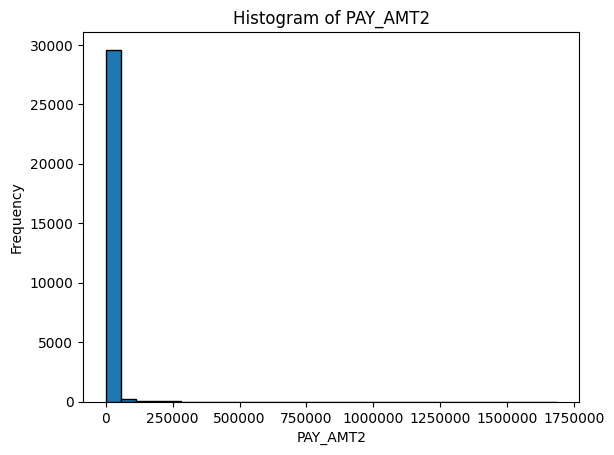

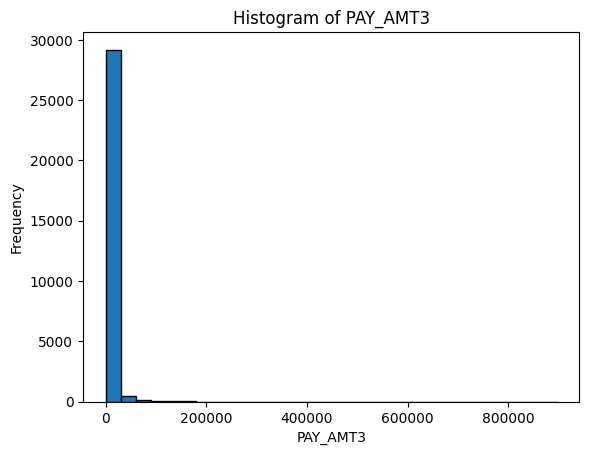

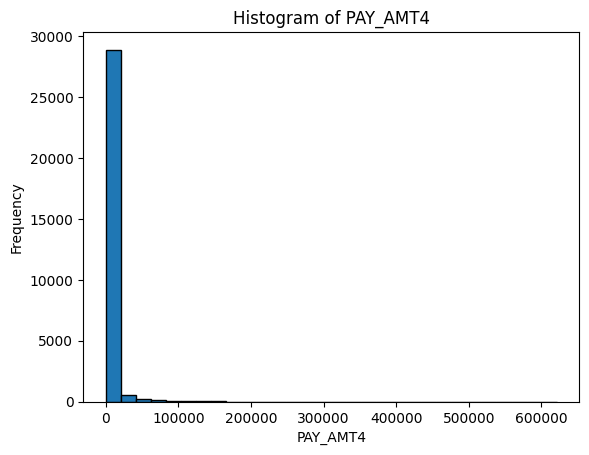

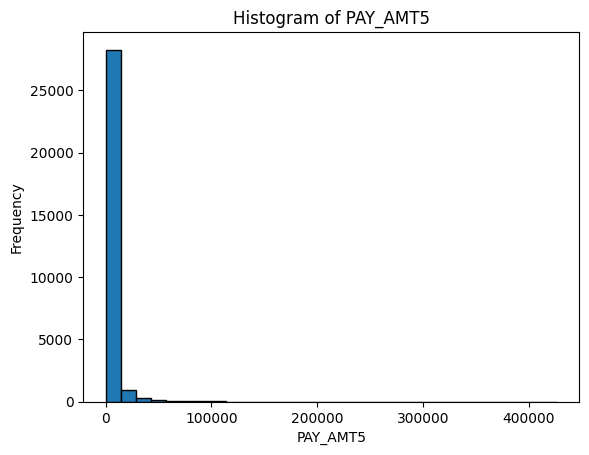

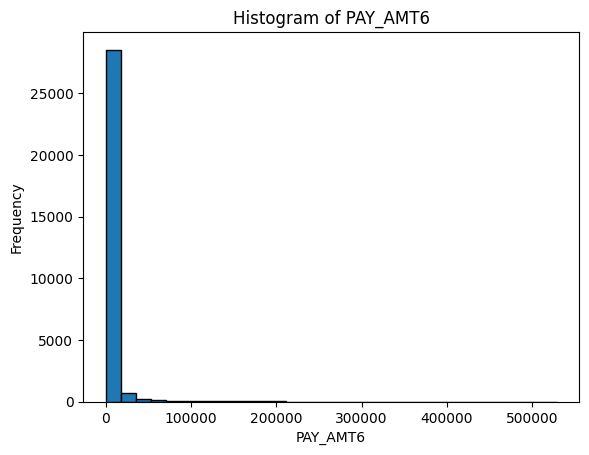

In [ ]:
for col in X.columns[0:23]:
    plt.hist(X[col], bins=30, edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.ticklabel_format(style='plain')
    plt.show()

In [ ]:
# Combine X and y into a new dataset to create boxplots of dependent vs. independent variables
combined_df = pd.concat([X, y], axis=1)

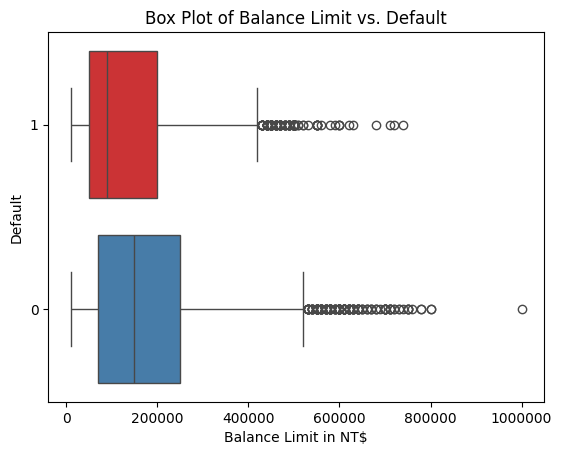

In [ ]:
sns.boxplot(x='LIMIT_BAL', y='default', hue='default', data=combined_df, palette='Set1')
plt.xlabel('Balance Limit in NT$')
plt.ylabel('Default')
plt.gca().ticklabel_format(axis='x', style='plain')
plt.title('Box Plot of Balance Limit vs. Default')
plt.show()

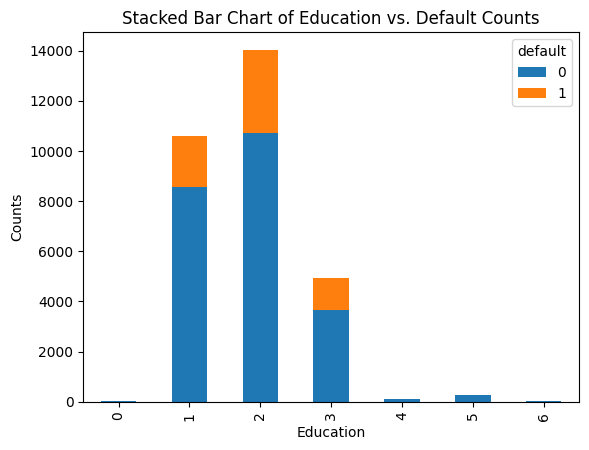

In [ ]:
pd.crosstab(combined_df['EDUCATION'], combined_df['default']).plot(kind='bar', stacked=True)
plt.xlabel('Education')
plt.ylabel('Counts')
plt.title('Stacked Bar Chart of Education vs. Default Counts')
plt.show()

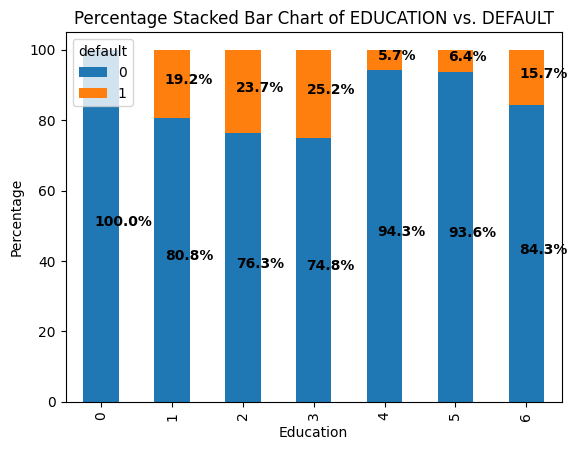

In [ ]:
# Calculate the percentage of counts in each bar for the stacked bar chart
edu_default_counts = combined_df.groupby(['EDUCATION', 'default']).size().unstack()
edu_default_percentages = edu_default_counts.div(edu_default_counts.sum(axis=1), axis=0) * 100


edu_default_percentages.plot(kind='bar', stacked=True)
plt.title('Percentage Stacked Bar Chart of EDUCATION vs. DEFAULT')
plt.xlabel('Education')
plt.ylabel('Percentage')

# Annotate the percentages on each bar
for n, x in enumerate([*edu_default_percentages.index.values]):
    for (proportion, y_loc) in zip(edu_default_percentages.loc[x],
                                   edu_default_percentages.loc[x].cumsum()):
        plt.text(x=n - 0.1,
                 y=(y_loc - proportion) + (proportion / 2),
                 s=f'{np.round(proportion, 1)}%',
                 color="black",
                 fontsize=10,
                 fontweight="bold")
plt.show()

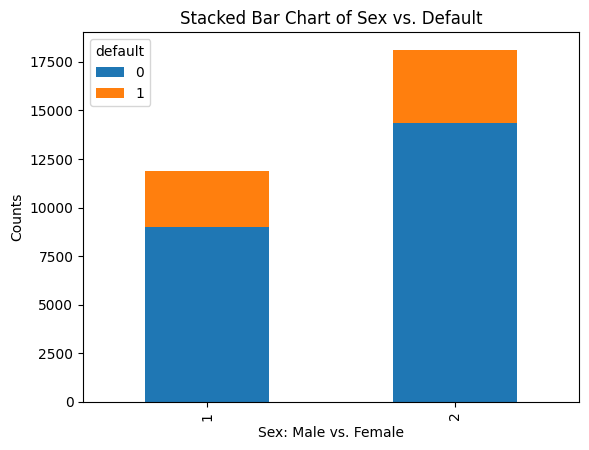

In [ ]:
pd.crosstab(combined_df['SEX'], combined_df['default']).plot(kind='bar',stacked=True)
plt.xlabel('Sex: Male vs. Female')
plt.ylabel('Counts')
plt.title('Stacked Bar Chart of Sex vs. Default')
plt.show()

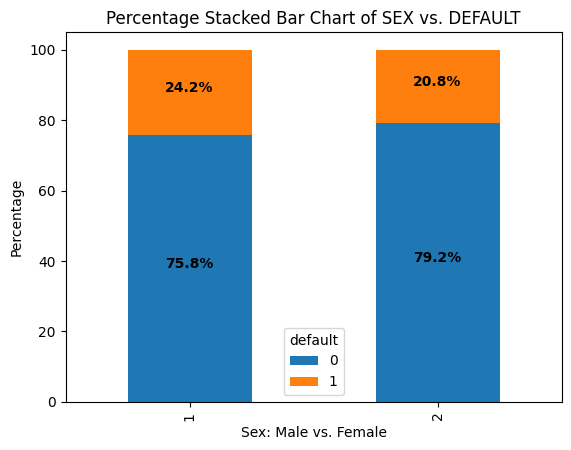

In [ ]:
# Calculate the percentage of counts in each bar for the stacked bar chart
sex_default_counts = combined_df.groupby(['SEX', 'default']).size().unstack()
sex_default_percentages = sex_default_counts.div(sex_default_counts.sum(axis=1), axis=0) * 100

sex_default_percentages.plot(kind='bar', stacked=True)
plt.title('Percentage Stacked Bar Chart of SEX vs. DEFAULT')
plt.xlabel('Sex: Male vs. Female')
plt.ylabel('Percentage')

# Annotate the percentages on each bar
for n, x in enumerate([*sex_default_percentages.index.values]):
    for (proportion, y_loc) in zip(sex_default_percentages.loc[x],
                                   sex_default_percentages.loc[x].cumsum()):
        plt.text(x=n - 0.1,
                 y=(y_loc - proportion) + (proportion / 2),
                 s=f'{np.round(proportion, 1)}%',
                 color="black",
                 fontsize=10,
                 fontweight="bold")
plt.show()

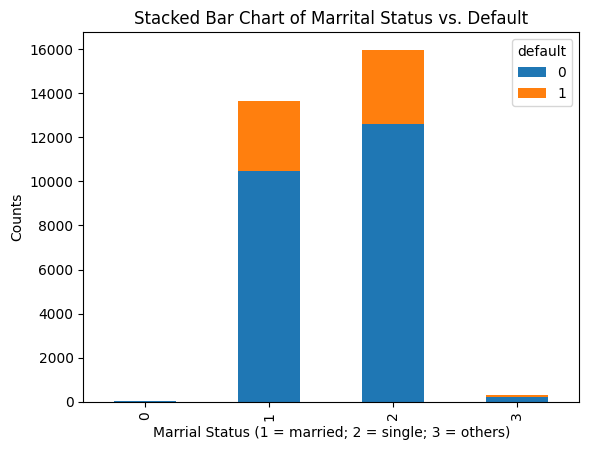

In [ ]:
pd.crosstab(combined_df['MARRIAGE'], combined_df['default']).plot(kind='bar',stacked=True)
plt.xlabel('Marrial Status (1 = married; 2 = single; 3 = others)')
plt.ylabel('Counts')
plt.title('Stacked Bar Chart of Marrital Status vs. Default')
plt.show()

**EDA Main Finding Summary**

There is class imbalance in our target variable - 22% of total customers have defaulted. The ratio between Default and Non-Default is about 1 to 3.

The box plot of Balance Limit vs. Default shows that customers who defaulted generally have lower balance limit than those who did not default.

The stacked bar chart and percentage bar chart of Education vs. Default shows that most customers in the bank have bachelor's degree and above. The university graduates have the highest counts of defaults, but in terms of the default percentages, the group with the highest default rate are the high school graduates.


# **Part 5. Model Building, Training, and Evaluations**

**Data Preprocessing**

Encode the target variable 'default' to numerical data type.

In [13]:
y = y.astype('int')

**Train/Test Split**

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=55)

### **Data Assumptions:**
In this project, we will make three assumptions about the data to train the ML models

1.   The training and test samples are drawn from the same underlying distribution and are independent of one another (i.i.d. data)
2.   There are no missing values (based on Part 2)
3.   The features, including those that have categorical meaning, can be and are best represented as numerical integers (based on Part 2)
4.   Since the overall goal is to predict default customers, the key metric that we'll use to evaluate the models is F1 score as it incorporates both precision and recall to measure how well the model can classify the true positives.



## **Tree Classifications and Ensembles**

**Model Assumptions:**

Tree-based models are non-parametric and make no explicit assumption about the functional form of the relationship between features and the target variable. They also don't make any assumptions about linearity and can model non-linear relationships between features and the target variable.

## Single Decision Tree Classifier

In [ ]:
# Create a DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=55)

# perform cross-validation
rsk = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
scores_tree = cross_val_score(tree, X_train, y_train, cv=rsk, scoring="f1")

# calculate the average MSE
avg_scores = np.mean(scores_tree)

print(f'Using cross validation, the average f1 score of a decision tree is {avg_scores}')

Using cross validation, the average f1 score of a decision tree is 0.39187757582327715


## Random Forest Classifier

In [16]:
forest = RandomForestClassifier(random_state=55)

# perform cross-validation
rsk = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
scores_rf = cross_val_score(forest, X_train, y_train, cv=rsk, scoring="f1")

# calculate the average MSE
avg_scores_rf = scores_rf.mean()

print(f'Using cross validation, the average f1 score of a random forest is {avg_scores_rf}')

Using cross validation, the average f1 score of a random forest is 0.4472382738355487


## Boosting Models: Gradient Boost, AdaBoost, and XGBoost

In [ ]:
import warnings
warnings.filterwarnings('ignore')

ada = AdaBoostClassifier(random_state=55)

rsk = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
scores_ada = cross_val_score(ada, X_train, y_train, cv=rsk, scoring="f1")
avg_scores_ada = scores_ada.mean()

print(f'Using cross validation, the average f1 score of an AdaBoost classifier is {avg_scores_ada}')

Using cross validation, the average f1 score of an AdaBoost classifier is 0.4177497557801314


In [ ]:
gradient = GradientBoostingClassifier(random_state=55)

rsk = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
scores_gradient = cross_val_score(gradient, X_train, y_train, cv=rsk, scoring="f1")
avg_scores_gradient = scores_gradient.mean()

print(f'Using cross validation, the average f1 score of a Gradient Boost classifier is {avg_scores_gradient}')

Using cross validation, the average f1 score of a Gradient Boost classifier is 0.4426677404628662


In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', n_estimators=100, random_state=55)
rsk = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=rsk,
                             scoring="f1")
avg_scores_xgb = scores_xgb.mean()

print(f'Using cross validation, the average f1 score of an XGBoost classifier is {avg_scores_xgb}')

Using cross validation, the average f1 score of an XGBoost classifier is 0.44221963327042024


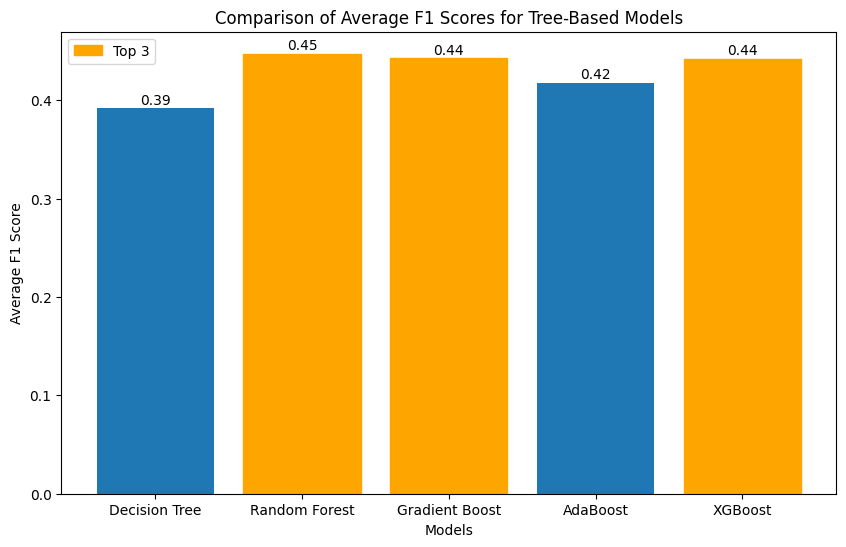

In [ ]:
f1_scores = {
    'Decision Tree': avg_scores,
    'Random Forest': avg_scores_rf,
    'Gradient Boost': avg_scores_gradient,
    'AdaBoost': avg_scores_ada,
    'XGBoost': avg_scores_xgb
}

models = list(f1_scores.keys())
scores = list(f1_scores.values())

plt.figure(figsize=(10, 6))
bar_chart = plt.bar(models, scores)

# Get bar heights and indices
heights = [bar.get_height() for bar in bar_chart.patches]
sorted_indices = np.argsort(heights)

# Highlight top three bars
for i in sorted_indices[-3:]:
    bar_chart.patches[i].set_color('orange')

# Add legend for highlighted bars
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='orange', label='Top 3')
plt.legend(handles=[red_patch])

# Add the score value on top of each bar
for i, v in enumerate(scores):
    plt.text(i, v + 0.001, str(round(v, 3)), ha='center', va='bottom')

plt.xlabel("Models")
plt.ylabel("Average F1 Score")
plt.title("Comparison of Average F1 Scores for Tree-Based Models")
plt.show()

## Hyperparameter Tuning for the Best Tree Models

From the above results, the models showing the best mean f1-scores are Random Forest, Gradient Boost, and XGBoost in this order. For these best performing models, we will fine tune their hyperparameters to select the optimal values and improve performance.

In [17]:
# Define the parameter grid for RandomForestClassifier
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object for RandomForestClassifier
grid_search_rf = GridSearchCV(estimator=forest, param_grid=param_grid_rf, cv=5, scoring='f1', n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search_rf.fit(X_train, y_train)

# Print the best hyperparameters and best score
print("Best hyperparameters for RandomForestClassifier:", grid_search_rf.best_params_)
print("Best f1 score for RandomForestClassifier:", grid_search_rf.best_score_)

Best hyperparameters for RandomForestClassifier: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best f1 score for RandomForestClassifier: 0.4591367478255621


In [ ]:
# Define the parameter grid for GradientBoostingClassifier
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

# Create a GridSearchCV object for GradientBoostingClassifier
grid_search_gb = GridSearchCV(estimator=gradient, param_grid=param_grid_gb, cv=5, scoring='f1', n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search_gb.fit(X_train, y_train)

# Print the best hyperparameters and best score
print("Best hyperparameters for GradientBoostingClassifier:", grid_search_gb.best_params_)
print("Best f1 score for GradientBoostingClassifier:", grid_search_gb.best_score_)

Best hyperparameters for GradientBoostingClassifier: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}
Best f1 score for GradientBoostingClassifier: 0.4439769938646355


In [ ]:
# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=55)

# Create a GridSearchCV object
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, scoring='f1', n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search_xgb.fit(X_train, y_train)

# Print the best hyperparameters and best score
print("Best hyperparameters for XGBoostClassifier:", grid_search_xgb.best_params_)
print("Best f1 score for XGBoostClassifier:", grid_search_xgb.best_score_)

Best hyperparameters for XGBoostClassifier: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best f1 score for XGBoostClassifier: 0.45649040580343153


## Threshold Tuning

Plot ROC curve and find the best classification threshold for random forest.

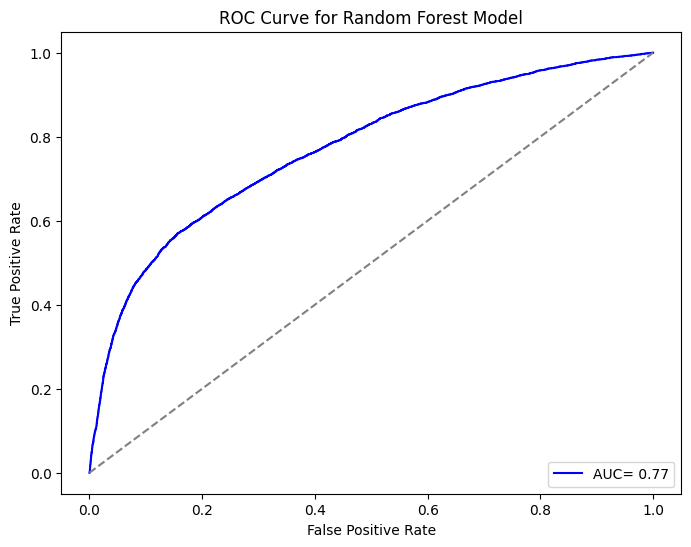

Best threshold: 0.3003699579517175


In [23]:
# Get the best random forest parameters from the grid search result from last step
best_rf = grid_search_rf.best_estimator_

# Fit the best random forest model
best_rf.fit(X_train, y_train)

# Get probability predictions on test (for class 1)
y_probs_rf = best_rf.predict_proba(X_test)[:, 1]  # Probabilities for class '1'

# Calculate ROC curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_probs_rf)

# Calculate the AUC
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', label= f'AUC= {roc_auc_rf:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Model')
plt.legend(loc='lower right')
plt.show()

# Calculate Youden's J statistic
youden_index_rf = tpr_rf - fpr_rf
best_threshold_index_rf = youden_index_rf.argmax()
best_threshold_rf = thresholds_rf[best_threshold_index_rf]

print(f'Best threshold: {best_threshold_rf}')

Evaluate the RF model on test with the updated threshold.

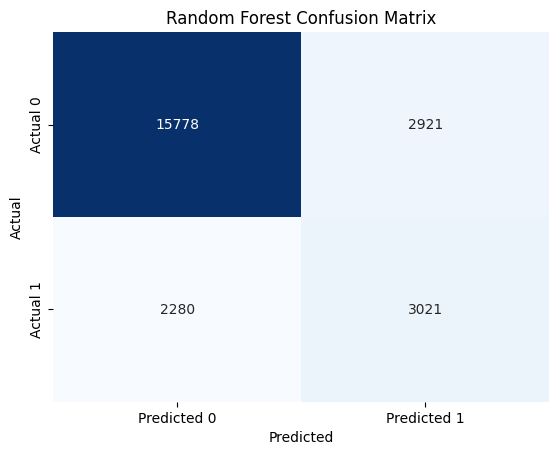

The final f1-score for the random forest model is: 0.5374010495419372


In [31]:
# Predict classes based on the best threshold
y_pred = (best_rf.predict_proba(X_test)[:, 1] >= best_threshold_rf).astype(int)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Calculate the score
f1_final_rf = f1_score(y_test, y_pred)
print(f"The final f1-score for the random forest model is: {f1_final_rf}")

Plot ROC curve and find the best classification threshold for gradient boost.

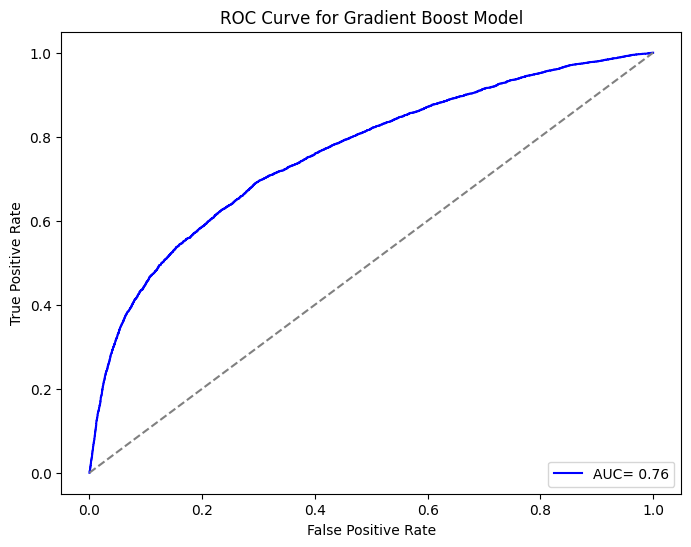

Best threshold for Gradient Boost: 0.1695439407395732


In [28]:
# Get the best gradient boost parameters from the grid search result from last step
best_gb = grid_search_gb.best_estimator_

# Fit the best gradient boost model
best_gb.fit(X_train, y_train)

# Get probability predictions on test (for class 1)
y_probs_gb = best_gb.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, y_probs_gb)

# Calculate the AUC
roc_auc_gb = auc(fpr_gb, tpr_gb)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, color='blue', label= f'AUC= {roc_auc_gb:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gradient Boost Model')
plt.legend(loc='lower right')
plt.show()

# Calculate Youden's J statistic
youden_index_gb = tpr_gb - fpr_gb
best_threshold_index_gb = youden_index_gb.argmax()
best_threshold_gb = thresholds_gb[best_threshold_index_gb]

print(f'Best threshold for Gradient Boost: {best_threshold_gb}')

Evaluate the Gradient Boost model on test with the updated threshold.

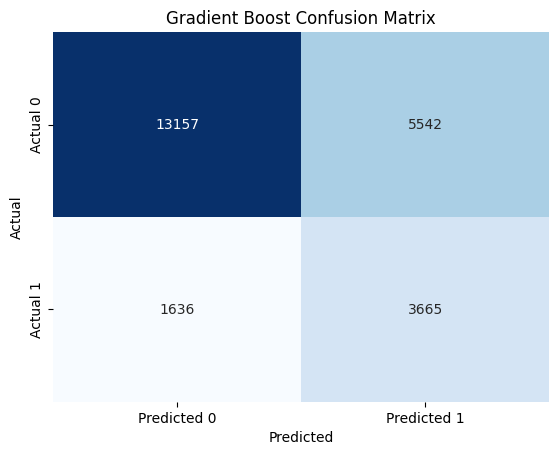

The final f1-score for the gradient boost model is: 0.5052384891094569


In [29]:
# Predict classes based on the best threshold
y_pred_gb = (best_gb.predict_proba(X_test)[:, 1] >= best_threshold_gb).astype(int)

# Create the confusion matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)

# Plot the confusion matrix
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Gradient Boost Confusion Matrix')
plt.show()

# Calculate the score
f1_final_gb = f1_score(y_test, y_pred_gb)
print(f"The final f1-score for the gradient boost model is: {f1_final_gb}")

Plot ROC curve and find the best classification threshold for XGBoost.

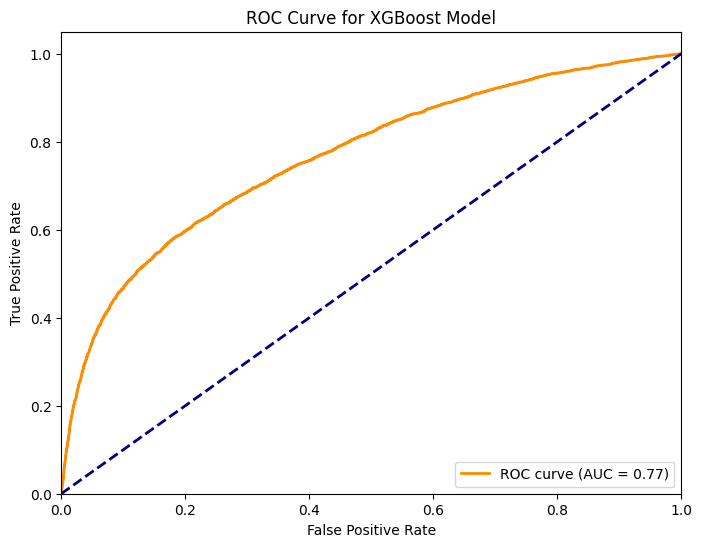

Optimal threshold for XGBoost: 0.2649570405483246


In [30]:
# Get the best xgboost parameters from the grid search result from last step
best_xgb = grid_search_xgb.best_estimator_

# Predict probabilities for the positive class (default)
y_probs_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_probs_xgb)

# Calculate the AUC
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Model')
plt.legend(loc="lower right")
plt.show()

# Find the optimal threshold using Youden's J statistic
youden_index_xgb = tpr_xgb - fpr_xgb
best_threshold_index_xgb = youden_index_xgb.argmax()
best_threshold_xgb = thresholds_xgb[best_threshold_index_xgb]

print(f"Optimal threshold for XGBoost: {best_threshold_xgb}")

Evaluate the XGBoost model on test with the updated threshold.

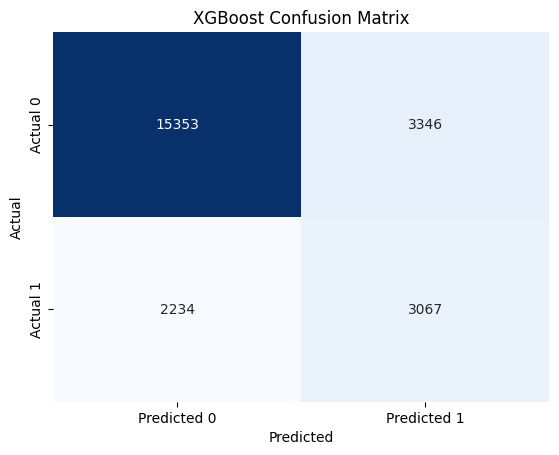

The final f1-score for the XGBoost model is: 0.5236469182175175


In [31]:
# Predict classes based on the best threshold
y_pred_xgb = (best_xgb.predict_proba(X_test)[:, 1] >= best_threshold_xgb).astype(int)

# Create the confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Plot the confusion matrix
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()

# Calculate the score
f1_final_xgb = f1_score(y_test, y_pred_xgb)
print(f"The final f1-score for the XGBoost model is: {f1_final_xgb}")

### Comparisons of Gradient Boost, XGBoost, and Random Forest


Make a plot to compare the f1-scores and AUCs for the models after hyperparameter tuning and threshold adjustments.

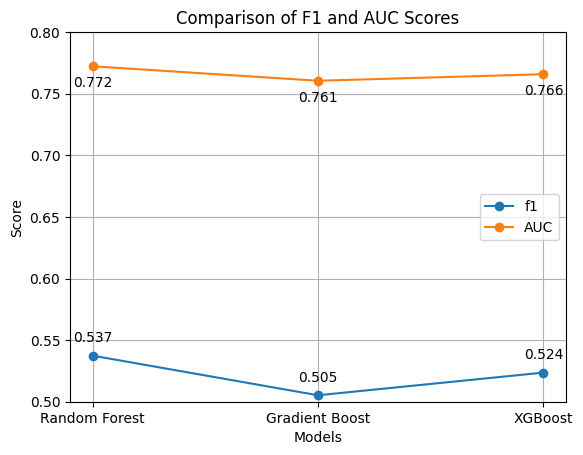

In [32]:
models = ['Random Forest', 'Gradient Boost', 'XGBoost']
f1 = [f1_final_rf, f1_final_gb, f1_final_xgb]
aucs = [roc_auc_rf, roc_auc_gb, roc_auc_xgb]

x = range(len(models))

plt.plot(x, f1, marker='o', label='f1')
plt.plot(x, aucs, marker='o', label='AUC')

# Annotate each point with its value
for i, txt in enumerate(f1):
    plt.annotate(f'{txt:.3f}', (x[i], f1[i]), textcoords="offset points", xytext=(0,10), ha='center')
for i, txt in enumerate(aucs):
    plt.annotate(f'{txt:.3f}', (x[i], aucs[i]), textcoords="offset points", xytext=(0,-15), ha='center')

plt.xticks(x, models)
plt.xlabel("Models")
plt.ylabel("Score")
plt.ylim(0.5, 0.8)
plt.title("Comparison of F1 and AUC Scores")
plt.legend()
plt.grid(True)
plt.show()

Compare the confusion matrices of the three models.

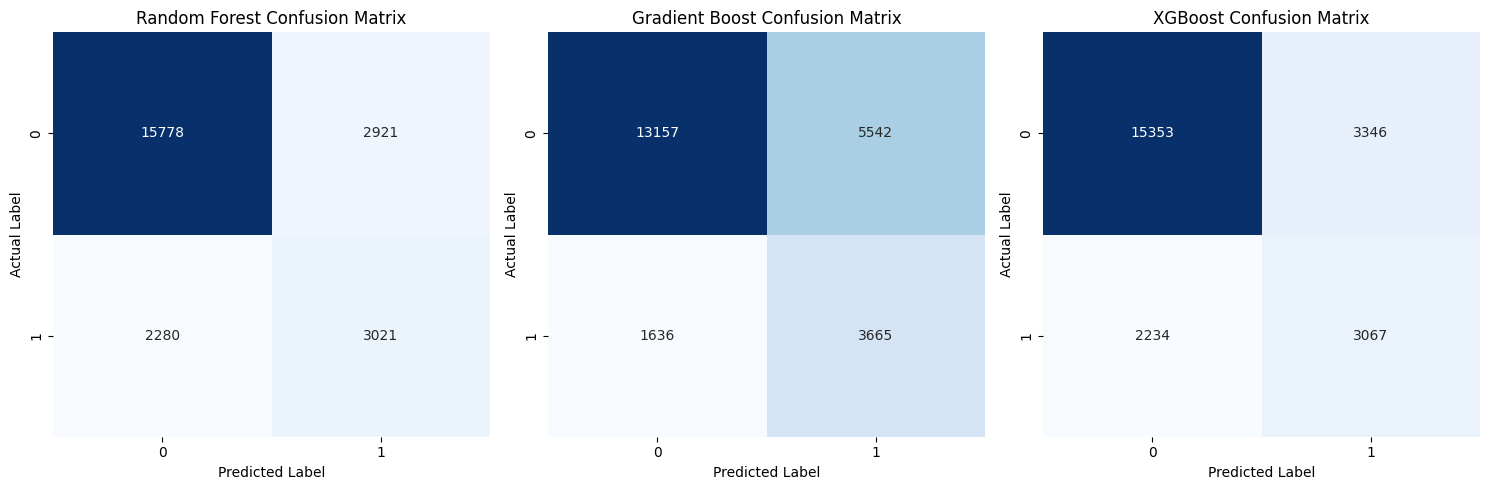

In [33]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the confusion matrix for random forest
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('Actual Label')

# Plot the confusion matrix for gradient boost
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_title('Gradient Boost Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('Actual Label')

# Plot the confusion matrix for xgboost
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[2])
axes[2].set_title('XGBoost Confusion Matrix')
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('Actual Label')

plt.tight_layout()
plt.show()

Based on the performance metrics plot, all three models have similar AUC around 0.76, with random forest and xgboost having minimally higher AUC of 0.77. This indicates similar degree of separability across the three models.

In terms of F1 score, random forest achieves highest F1 score, demonstrating a good balance between precision and recall. XGBoost closely follows random forest in the second place. Both models perform significantly better than gradient boost.

When comparing the confusion matrices, we can see the reasons why gradient boost performs worse than the other models - it produces too many false positives (upper right square), even though it also predicted the highest number of true positve instances. Random forest and XGBoost demonstrates similar performance in capturing the true labels. Specifically, random forest performs slightly better in the true negatives, and XGBoost has a slight edge in the true positive instances, but the differences between the models are small. However, we can see that to obtain small increase in the true positives, XGBoost resulted in higher number of false positives than random forest, leading to slightly lower f1 score in comparison. Although the performances of the two models are close, **random forest performs the best in all key metrics so it is the winner of the tree models**, and we will use random forest for feature importance analysis.

## **Other Models (KNN, SVM, Bayes)**

Preprocess the training and test features for SVM, KNN, and Bayes models.

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## K Nearest Neighbors

**Model Assumption:**
KNN assumes that data points that are close in the feature space are more likely to belong to the same class

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(weights='distance')

rsk = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
scores_knn = cross_val_score(knn, X_train_scaled, y_train, cv=rsk, scoring="f1")
avg_scores_knn = scores_knn.mean()

print(f'Using cross validation, the average f1 score of a KNN classifier is {avg_scores_knn: .4e}')

Using cross validation, the average f1 score of a KNN classifier is  3.9745e-01


## Support Vector Machine (SVM)

**Linear Support Vector Machine Classifier**

**Model Assumption:** Data is linearly separable or can be separated by a hyperplane in the original feature space.

In [19]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

lsvc = LinearSVC()

rsk = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
scores_lsvc = cross_val_score(lsvc, X_train_scaled, y_train, cv=rsk, scoring="f1")
avg_scores_lsvc = scores_lsvc.mean()

print(f'The average f1 score of a Linear SVC classifier is {avg_scores_lsvc: .4e}')

The average f1 score of a Linear SVC classifier is  4.4313e-01


**Support Vector Machine with Kernels**

**Model Assumption:** Data is seperable in a transformed, or higher dimensional, feature space.

In [ ]:
rbf_svc = SVC(kernel='rbf', max_iter=-1)

rsk = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
scores_rbf = cross_val_score(rbf_svc, X_train_scaled, y_train, cv=rsk, scoring="f1")
avg_scores_rbf = scores_rbf.mean()

print(f'The average f1 score of a RBF SVC classifier is {avg_scores_rbf: .4e}')

The average f1 score of a RBF SVC classifier is  4.3971e-01


In [ ]:
sig_svc = SVC(kernel='sigmoid', max_iter=5000)

rsk = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
scores_sig = cross_val_score(sig_svc, X_train_scaled, y_train, cv=rsk, scoring="f1")
avg_scores_sig = scores_sig.mean()

print(f'The average f1 score of a Sigmoid SVC classifier is {avg_scores_sig: .4e}')

The average f1 score of a Sigmoid SVC classifier is  3.5969e-01


In [ ]:
poly_svc = SVC(kernel='poly', max_iter=-1)

rsk = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
scores_poly = cross_val_score(poly_svc, X_train_scaled, y_train, cv=rsk, scoring="f1")
avg_scores_poly = scores_poly.mean()

print(f'The average f1 score of a Polynomial SVC classifier is {avg_scores_poly: .4e}')

The average f1 score of a Polynomial SVC classifier is  3.8937e-01


## Gaussian Naive Bayes

**Model Assumption:**
All features are conditionally independent of each other under the same class label.
Each feature follows a Gaussian distribution within each class.
Assumes no interaction or dependence between features.

In [39]:
from sklearn.naive_bayes import GaussianNB

# Initialize Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Perform cross-validation
rsk = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
scores_gnb = cross_val_score(gnb, X_train_scaled, y_train, cv=rsk, scoring="f1")

# Calculate the average MSE
avg_scores_gnb = scores_gnb.mean()

print(f'The average f1 score of a Gaussian Naive Bayes classifier is {avg_scores_gnb: .4e}')

The average f1 score of a Gaussian Naive Bayes classifier is  4.6514e-01


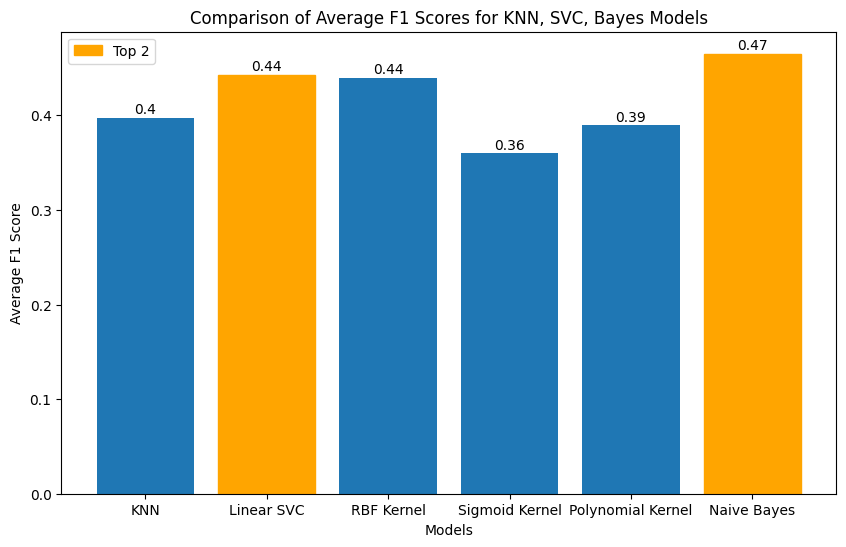

In [ ]:
f1_scores = {
    'KNN': avg_scores_knn,
    'Linear SVC': avg_scores_lsvc,
    'RBF Kernel': avg_scores_rbf,
    'Sigmoid Kernel': avg_scores_sig,
    'Polynomial Kernel': avg_scores_poly,
    'Naive Bayes': avg_scores_gnb
}

models = list(f1_scores.keys())
scores = list(f1_scores.values())

plt.figure(figsize=(10, 6))
bar_chart = plt.bar(models, scores)

# Get bar heights and indices
heights = [bar.get_height() for bar in bar_chart.patches]
sorted_indices = np.argsort(heights)

# Highlight top two bars
for i in sorted_indices[-2:]:
    bar_chart.patches[i].set_color('orange')

# Add legend for highlighted bars
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='orange', label='Top 2')
plt.legend(handles=[red_patch])

# Add the score value on top of each bar
for i, v in enumerate(scores):
    plt.text(i, v + 0.001, str(round(v, 2)), ha='center', va='bottom')

plt.xlabel("Models")
plt.ylabel("Average F1 Score")
plt.title("Comparison of Average F1 Scores for KNN, SVC, Bayes Models")
plt.show()

## Hyperparameter Tuning for the 2 Best Models

In all the SVM, NB, and KNN models, the top two performing models are Naive Bayes and Linear SVC. We will find the best combinations of hyperparameters before fine tuning the threshold values.


In [40]:
# Define the parameter grid for Gaussian Naive Bayes
param_grid_gnb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

# Create a GridSearchCV object for Gaussian Naive Bayes
grid_search_gnb = GridSearchCV(estimator=gnb, param_grid=param_grid_gnb, cv=5, scoring='f1', n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search_gnb.fit(X_train_scaled, y_train)

# Print the best hyperparameters and best score
print("Best hyperparameters for Gaussian Naive Bayes:", grid_search_gnb.best_params_)
print("Best f1 score for Gaussian Naive Bayes:", grid_search_gnb.best_score_)

Best hyperparameters for Gaussian Naive Bayes: {'var_smoothing': 0.04328761281083057}
Best f1 score for Gaussian Naive Bayes: 0.45961346781908974


In [20]:
# Define the parameter grid for LinearSVC
param_grid_lsvc = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
}

# Create a GridSearchCV object for LinearSVC
grid_search_lsvc = GridSearchCV(estimator=lsvc, param_grid=param_grid_lsvc, cv=5, scoring='f1', n_jobs=-1)

# Fit the GridSearchCV object to the scaled training data
grid_search_lsvc.fit(X_train_scaled, y_train)

# Print the best hyperparameters and best score
print("Best hyperparameters for LinearSVC:", grid_search_lsvc.best_params_)
print("Best f1 score for LinearSVC:", grid_search_lsvc.best_score_)

Best hyperparameters for LinearSVC: {'C': 0.1, 'penalty': 'l1'}
Best f1 score for LinearSVC: 0.44487326625088164


## Threshold Tuning

Plot ROC curve and find the best classification threshold for Gaussian Naive Bayes.

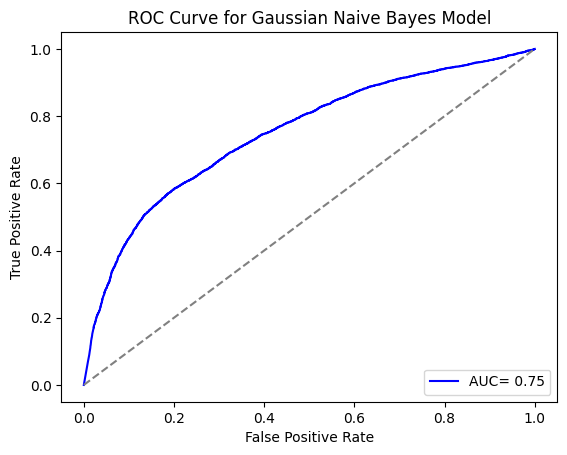

Best threshold for Gaussian Naive Bayes: 0.11821929234918246


In [41]:
# Get the best bayes parameters from the grid search result from last step
best_gnb = grid_search_gnb.best_estimator_

# Fit the best gradient boost model
best_gnb.fit(X_train_scaled, y_train)

# Get probability predictions on test (for class 1)
y_probs_gnb = best_gnb.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_test, y_probs_gnb)

# Calculate the AUC
roc_auc_gnb = auc(fpr_gnb, tpr_gnb)

# Plot ROC curve
plt.plot(fpr_gnb, tpr_gnb, color='blue', label= f'AUC= {roc_auc_gnb:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gaussian Naive Bayes Model')
plt.legend(loc='lower right')
plt.show()

# Calculate Youden's J statistic
youden_index_gnb = tpr_gnb - fpr_gnb
best_threshold_index_gnb = youden_index_gnb.argmax()
best_threshold_gnb = thresholds_gnb[best_threshold_index_gnb]

print(f'Best threshold for Gaussian Naive Bayes: {best_threshold_gnb}')

Evaluate the Naive Bayes model on test with the updated threshold.

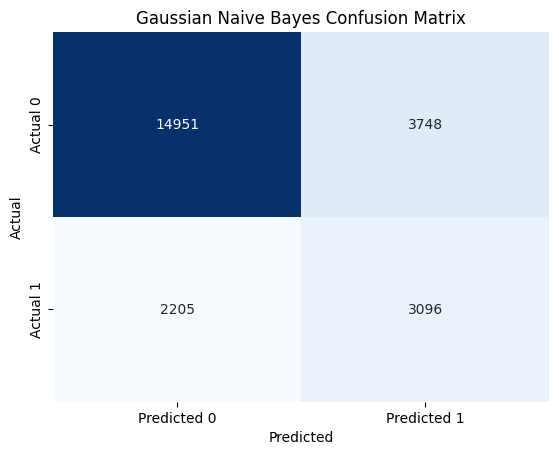

The final f1-score for the Gaussian Naive Bayes model is: 0.5098394400988061


In [42]:
# Predict classes based on the best threshold
y_pred_gnb = (best_gnb.predict_proba(X_test_scaled)[:, 1] >= best_threshold_gnb).astype(int)

# Create the confusion matrix
cm_gnb = confusion_matrix(y_test, y_pred_gnb)

# Plot the confusion matrix
sns.heatmap(cm_gnb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Gaussian Naive Bayes Confusion Matrix')
plt.show()

# Calculate the score
f1_final_gnb = f1_score(y_test, y_pred_gnb)

print(f"The final f1-score for the Gaussian Naive Bayes model is: {f1_final_gnb}")

Plot ROC curve and find the best classification threshold for Linear SVC.

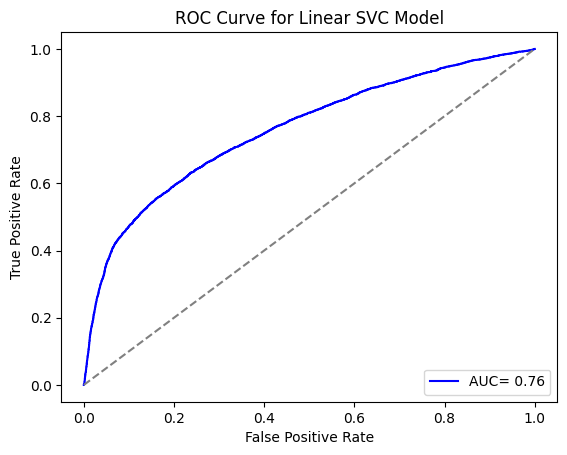

Best threshold: -0.5814072675098717


In [24]:
# Get the best bayes parameters from the grid search result from last step
best_lsvc = grid_search_lsvc.best_estimator_

# Fit the best linear svc model
best_lsvc.fit(X_train_scaled, y_train)

# Get probability predictions
y_probs_lsvc = best_lsvc.decision_function(X_test_scaled)

# Calculate ROC curve
fpr_lsvc, tpr_lsvc, thresholds_lsvc = roc_curve(y_test, y_probs_lsvc)

# Calculate the AUC
roc_auc_lsvc = auc(fpr_lsvc, tpr_lsvc)

# Plot ROC curve
plt.plot(fpr_lsvc, tpr_lsvc, color='blue', label= f'AUC= {roc_auc_lsvc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Linear SVC Model')
plt.legend(loc='lower right')
plt.show()

# Calculate Youden's J statistic
youden_index_lsvc = tpr_lsvc - fpr_lsvc
best_threshold_index_lsvc = youden_index_lsvc.argmax()
best_threshold_lsvc = thresholds_lsvc[best_threshold_index_lsvc]

print(f'Best threshold: {best_threshold_lsvc}')

Evaluate the Linear SVC model on test with the updated threshold.



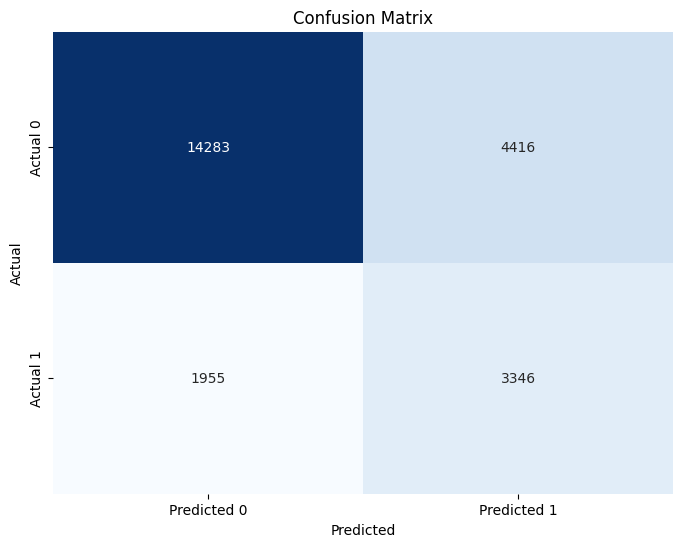

The final f1-score for the Linear SVC model is: 0.5122866110388119


In [32]:
# Predict classes based on the best threshold
y_pred_lsvc = (best_lsvc.decision_function(X_test_scaled) >= best_threshold_lsvc).astype(int)

# Create the confusion matrix
cm_lsvc = confusion_matrix(y_test, y_pred_lsvc)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lsvc, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate the f1 score
f1_final_lsvc = f1_score(y_test, y_pred_lsvc)
print(f"The final f1-score for the Linear SVC model is: {f1_final_lsvc}")

### Comparison of Gaussian Naive Bayes and Linear SVC

Make a plot to compare the f1-scores and AUCs for the models after hyperparameter tuning and threshold adjustments.

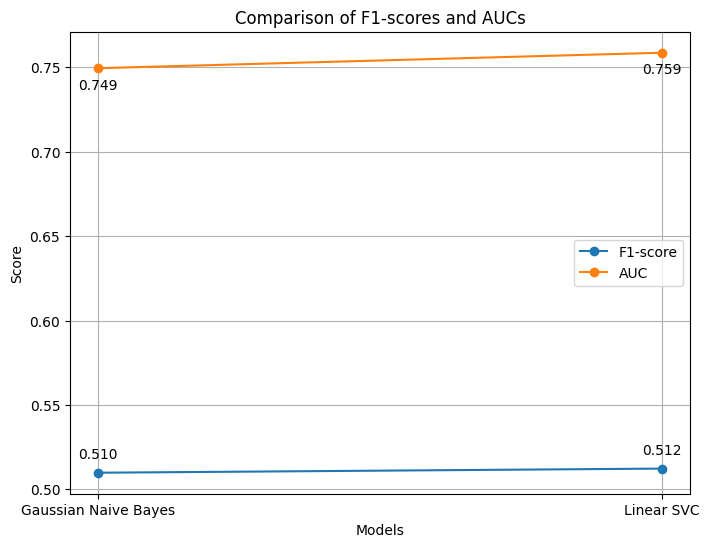

In [43]:
models = ['Gaussian Naive Bayes', 'Linear SVC']
f1_scores = [f1_final_gnb, f1_final_lsvc]
aucs = [roc_auc_gnb, roc_auc_lsvc]

x = range(len(models))

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, f1_scores, marker='o', label='F1-score')
plt.plot(x, aucs, marker='o', label='AUC')

# Annotate each point with its value
for i, txt in enumerate(f1_scores):
    plt.annotate(f'{txt:.3f}', (x[i], f1_scores[i]), textcoords="offset points", xytext=(0,10), ha='center')
for i, txt in enumerate(aucs):
    plt.annotate(f'{txt:.3f}', (x[i], aucs[i]), textcoords="offset points", xytext=(0,-15), ha='center')

plt.xticks(x, models)
plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Comparison of F1-scores and AUCs")
plt.legend()
plt.grid(True)
plt.show()

Compare the confusion matrices of the two models.

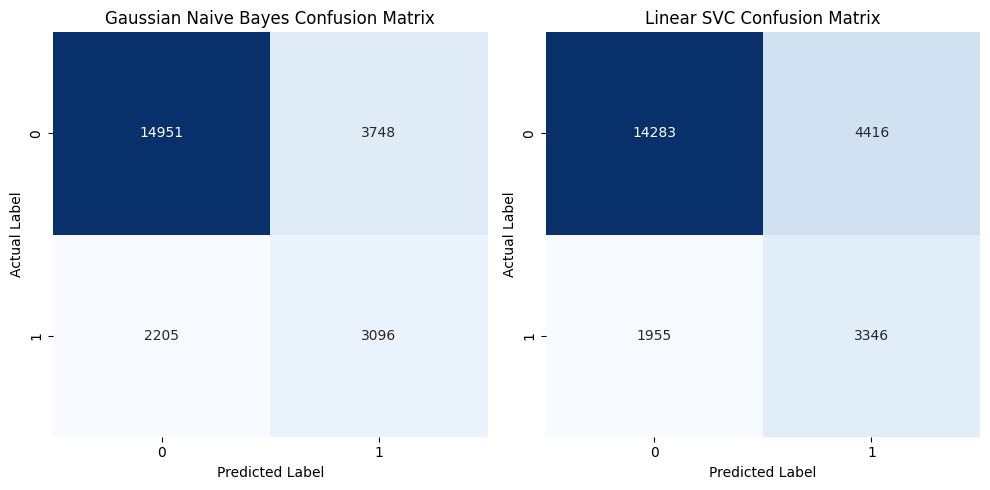

In [44]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the confusion matrix for random forest
sns.heatmap(cm_gnb, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Gaussian Naive Bayes Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('Actual Label')

# Plot the confusion matrix for gradient boost
sns.heatmap(cm_lsvc, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_title('Linear SVC Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('Actual Label')

plt.tight_layout()
plt.show()

## Artificial Neural Network

In [ ]:
mlp = MLPClassifier(random_state=55, max_iter=1000)

rsk = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
scores_mlp = cross_val_score(mlp, X_train_scaled, y_train, cv=rsk, scoring="f1")
avg_scores_mlp = scores_mlp.mean()

print(f'The average f1 score of a MLP classifier is {avg_scores_mlp: .4e}')

The average f1 score of a MLP classifier is  4.2331e-01


Find the optimal hyperparameters for the multilayer perceptron model.

In [ ]:
activation_functions = ['identity', 'logistic', 'tanh', 'relu']
optimization_functions = ['lbfgs', 'sgd', 'adam']
alpha_values = [0.0001, 0.001, 0.01, 0.1, 1.0]
hidden_layer_configs = [(100,), (50,50), (30,30,30)]

In [ ]:
# Dictionary to store F1 scores for each activation function
atv_results = {}

# Loop through activation functions
for activation in activation_functions:

    mlp = MLPClassifier(activation=activation, max_iter=1500, random_state=63)

    # Fit the model to the training data
    mlp.fit(X_train_scaled, y_train)

    # Predict on the test data
    y_pred = mlp.predict(X_test_scaled)

    # Calculate the F1 score
    f1 = f1_score(y_test, y_pred, average='binary')

    # Store the F1 score in the dictionary
    atv_results[activation] = f1

# Find the activation function with the highest F1 score
best_activation = max(atv_results, key=atv_results.get)
print(f"The best activation function is: {best_activation} with an F1 score of {atv_results[best_activation]:.4f}.")

The best activation function is: identity with an F1 score of 0.4827.


In [ ]:
# Dictionary to store F1 scores for each optimization function
op_results = {}

for opt in optimization_functions:
    mlp = MLPClassifier(activation='identity', solver=opt, random_state=63)
    mlp.fit(X_train_scaled, y_train)
    y_pred = mlp.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred, average='binary')
    op_results[opt] = f1

# Find the optimization function with the highest F1 score
best_opt = max(op_results, key=op_results.get)
print(f"The best optimization function is: {best_opt} with an F1 score of {op_results[best_opt]:.4f}.")

The best optimization function is: adam with an F1 score of 0.4827.


In [ ]:
# Dictionary to store F1 scores for each alpha value
reg_results = {}

for alpha in alpha_values:
    mlp = MLPClassifier(activation='identity', solver='adam', alpha=alpha, random_state=63)
    mlp.fit(X_train_scaled, y_train)
    y_pred = mlp.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred, average='binary')
    reg_results[alpha] = f1

# Find the regularization with the highest F1 score
best_reg = max(reg_results, key=reg_results.get)
print(f"The best regularization strength is: {best_reg} with an F1 score of {reg_results[best_reg]:.4f}.")

The best regularization strength is: 0.01 with an F1 score of 0.4829.


In [ ]:
# Dictionary to store F1 scores for each hidden layer configuation
hidden_results = {}

for config in hidden_layer_configs:
    mlp = MLPClassifier(activation='identity', solver='adam',
                        alpha=0.01, hidden_layer_sizes=config, random_state=63)
    mlp.fit(X_train_scaled, y_train)
    y_pred = mlp.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred, average='binary')
    hidden_results[config] = f1

# Find the hidden layer configuation with the highest F1 score
best_layer = max(hidden_results, key=hidden_results.get)
print(f"The best layer is: {best_layer} with an F1 score of {hidden_results[best_layer]:.4f}.")

The best layer is: (100,) with an F1 score of 0.4829.


Store the best performing MLP model.

In [21]:
best_mlp = MLPClassifier(activation='identity', solver='adam',
                        alpha=0.01, hidden_layer_sizes=(100,), random_state=63)
best_mlp.fit(X_train_scaled, y_train)
y_pred_mlp = best_mlp.predict(X_test_scaled)
f1 = f1_score(y_test, y_pred_mlp, average='binary')
print(f'F1 score of the best performing MLP is {f1}')

F1 score of the best performing MLP is 0.482897384305835


MLP Threshold Tuning

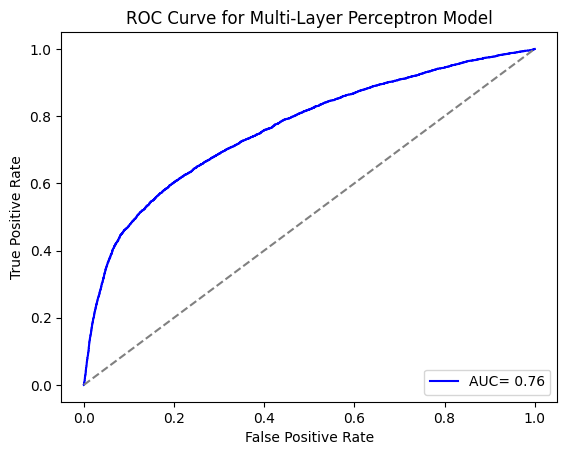

Best threshold for Multi-Layer Perceptron: 0.22982076863785666


In [34]:
# Fit the best gradient boost model
best_mlp.fit(X_train_scaled, y_train)

# Get probability predictions on test (for class 1)
y_probs_mlp = best_mlp.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, y_probs_mlp)

# Calculate the AUC
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# Plot ROC curve
plt.plot(fpr_mlp, tpr_mlp, color='blue', label= f'AUC= {roc_auc_mlp:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Layer Perceptron Model')
plt.legend(loc='lower right')
plt.show()

# Calculate Youden's J statistic
youden_index_mlp = tpr_mlp - fpr_mlp
best_threshold_index_mlp = youden_index_mlp.argmax()
best_threshold_mlp = thresholds_mlp[best_threshold_index_mlp]

print(f'Best threshold for Multi-Layer Perceptron: {best_threshold_mlp}')

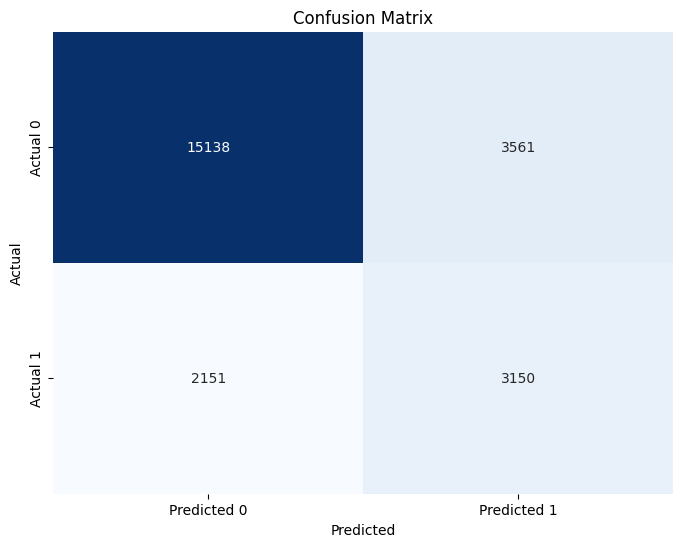

The final f1-score for the MLP model is: 0.5244755244755245


In [35]:
# Predict classes based on the best threshold
y_pred_mlp = (best_mlp.predict_proba(X_test_scaled)[:,1] >= best_threshold_mlp).astype(int)

# Create the confusion matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate the f1 score
f1_final_mlp = f1_score(y_test, y_pred_mlp)
print(f"The final f1-score for the MLP model is: {f1_final_mlp}")

## Comparison of Top Single Models

In the three model sections above, the best models in each section are Random Forest, Linear SVC, and Multi-Layer Perceptron. We will analyze and compare the performances of the top models to better understand their strengths and weaknesses.

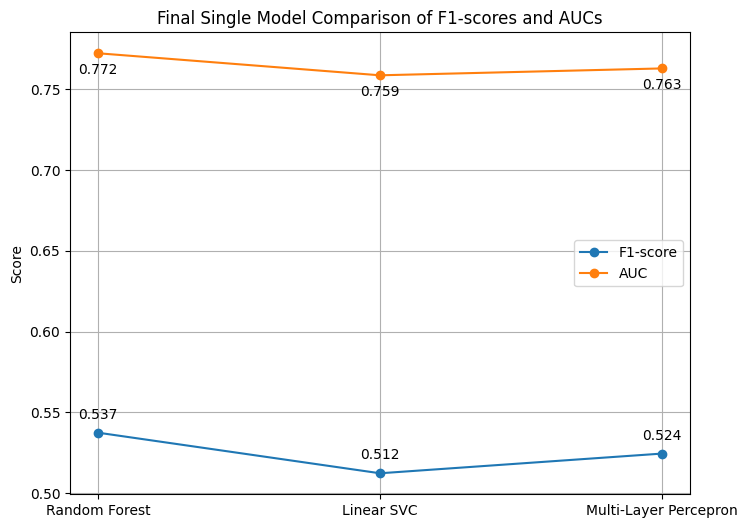

In [49]:
models = ['Random Forest', 'Linear SVC', 'Multi-Layer Percepron']
f1_scores = [f1_final_rf, f1_final_lsvc, f1_final_mlp]
aucs = [roc_auc_rf, roc_auc_lsvc, roc_auc_mlp]

x = range(len(models))

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, f1_scores, marker='o', label='F1-score')
plt.plot(x, aucs, marker='o', label='AUC')

# Annotate each point with its value
for i, txt in enumerate(f1_scores):
    plt.annotate(f'{txt:.3f}', (x[i], f1_scores[i]), textcoords="offset points", xytext=(0,10), ha='center')
for i, txt in enumerate(aucs):
    plt.annotate(f'{txt:.3f}', (x[i], aucs[i]), textcoords="offset points", xytext=(0,-15), ha='center')

plt.xticks(x, models)
plt.ylabel("Score")
plt.title("Final Single Model Comparison of F1-scores and AUCs")
plt.legend()
plt.grid(True)
plt.show()

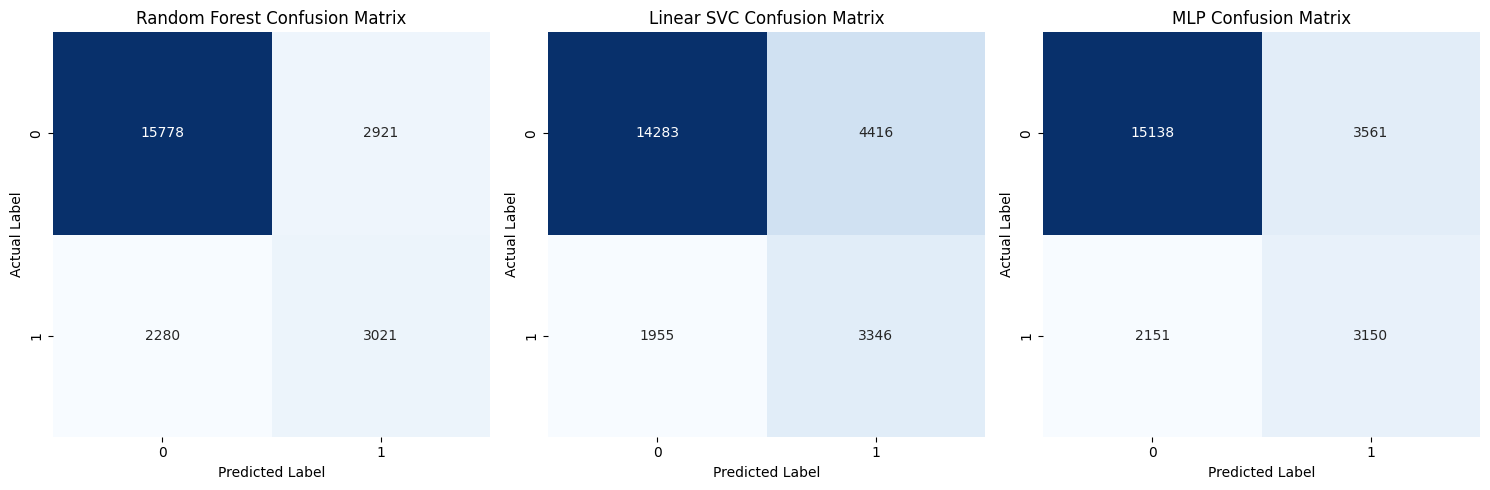

In [52]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the confusion matrix for random forest
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('Actual Label')

# Plot the confusion matrix for gradient boost
sns.heatmap(cm_lsvc, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_title('Linear SVC Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('Actual Label')

# Plot the confusion matrix for gradient boost
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[2])
axes[2].set_title('MLP Confusion Matrix')
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('Actual Label')

plt.tight_layout()
plt.show()

When solely comparing the metric results of f1-score and AUC, random forest outperforms both Linear SVM and MLP. Multi-layer percetron showed strong performance just marginally behind random forest. A closer look at the confusion matrices reveals that most of the accuracy of random forest comes from the true negative instances, while the number of correctly predicted positive instances are the least among the models. Linear SVC has the highest number of true positives, but it also made many mistakes in the process, producing more than 4000 false positives. MLP offers a balance between the two, with moderately high number of true positives and negatives. **Overall, Random Forest and MLP demonstrated comparable robust performance.** Random forest is the most reliable model with the optimal harmonic mean of precision and recall. It is also more suitable when model interpretability and understanding the decision-making process is important. On the other hand, MLP offers better capability to capture the positive instances and excels in modeling more complex, non-linear patterns in large datasets.


## Stacked Ensemble

Using the best models from random forest and gradient boosting, we will combine the models to experiment with a stacking model and see if it will lead to a even better score.

In [26]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [55]:
# Stacked ensemble with Random Forest, MLP, and the meta-learner is logistic regression
estimators = [('rf', best_rf), ('mlp', best_mlp)]

meta_estimator = LogisticRegression(random_state=55)

stacking_model = StackingClassifier(estimators=estimators, final_estimator=meta_estimator)

scores_stacking = cross_val_score(stacking_model, X_train_scaled, y_train, cv=5, scoring="f1")
avg_scores_stacking = scores_stacking.mean()
print(f'Using cross validation, the average f1 score of a stacking model is {avg_scores_stacking: .4e}')

Using cross validation, the average f1 score of a stacking model is  4.4441e-01


In [27]:
# Stacked ensemble with Random Forest, MLP, LSVC, and the meta-learner is logistic regression
estimators = [('rf', best_rf), ('mlp', best_mlp), ('lsvc', best_lsvc)]

meta_estimator = LogisticRegression(random_state=55)

stacking_model = StackingClassifier(estimators=estimators, final_estimator=meta_estimator)

scores_stacking = cross_val_score(stacking_model, X_train_scaled, y_train, cv=5, scoring="f1")
avg_scores_stacking = scores_stacking.mean()
print(f'Using cross validation, the average f1 score of a stacking model is {avg_scores_stacking: .4e}')

Using cross validation, the average f1 score of a stacking model is  4.4923e-01


Hyperparameter Tuning and Threshold Tuning for Stacking model

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_stacking.py", line 672, in fit
    return super().fit(X, y_encoded, sample_weight)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python

Best hyperparameters for Stacking Classifier: {'final_estimator__C': 10, 'final_estimator__penalty': 'l2'}
Best f1 score for Stacking Classifier: 0.4532944150977746
F1-score on test set: 0.4807715491259795


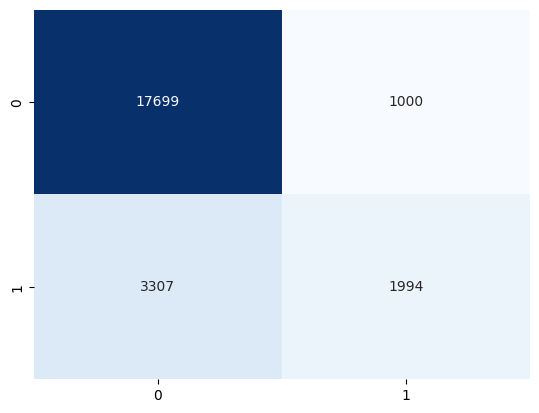

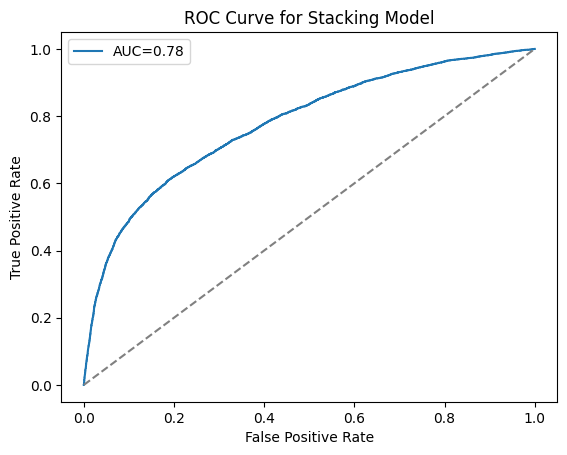

Best Threshold: 0.2163269342467844


In [28]:
# Define the parameter grid for the stacking classifier
param_grid = {
    'final_estimator__C': [0.1, 1, 10],  # Parameters for Logistic Regression
    'final_estimator__penalty': ['l1', 'l2'], # Parameters for Logistic Regression
}

# Create the stacking classifier with the best base estimators
estimators = [('rf', best_rf), ('mlp', best_mlp), ('lsvc', best_lsvc)]
meta_estimator = LogisticRegression(random_state=55)
stacking_model = StackingClassifier(estimators=estimators, final_estimator=meta_estimator)

# Create a GridSearchCV object for the stacking classifier
grid_search_stacking = GridSearchCV(estimator=stacking_model, param_grid=param_grid, cv=5, scoring="f1", n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search_stacking.fit(X_train_scaled, y_train)

# Print the best hyperparameters and best score
print("Best hyperparameters for Stacking Classifier:", grid_search_stacking.best_params_)
print("Best f1 score for Stacking Classifier:", grid_search_stacking.best_score_)


# Get the best stacking model
best_stacking_model = grid_search_stacking.best_estimator_

# Evaluate on the test set
y_pred_stacking = best_stacking_model.predict(X_test_scaled)
f1_stacking = f1_score(y_test, y_pred_stacking)

print(f"F1-score on test set: {f1_stacking}")

# Confusion matrix for stacking
cm_stacking = confusion_matrix(y_test, y_pred_stacking)
sns.heatmap(cm_stacking, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.show()


# ROC Curve and threshold tuning for stacking
y_probs_stacking = best_stacking_model.predict_proba(X_test_scaled)[:, 1]
fpr_stacking, tpr_stacking, thresholds_stacking = roc_curve(y_test, y_probs_stacking)
roc_auc_stacking = auc(fpr_stacking, tpr_stacking)

plt.plot(fpr_stacking, tpr_stacking, label=f"AUC={roc_auc_stacking:.2f}")
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Stacking Model")
plt.legend()
plt.show()

# Optimal Threshold
youden_index_stacking = tpr_stacking - fpr_stacking
best_threshold_index_stacking = youden_index_stacking.argmax()
best_threshold_stacking = thresholds_stacking[best_threshold_index_stacking]
print(f"Best Threshold: {best_threshold_stacking}")

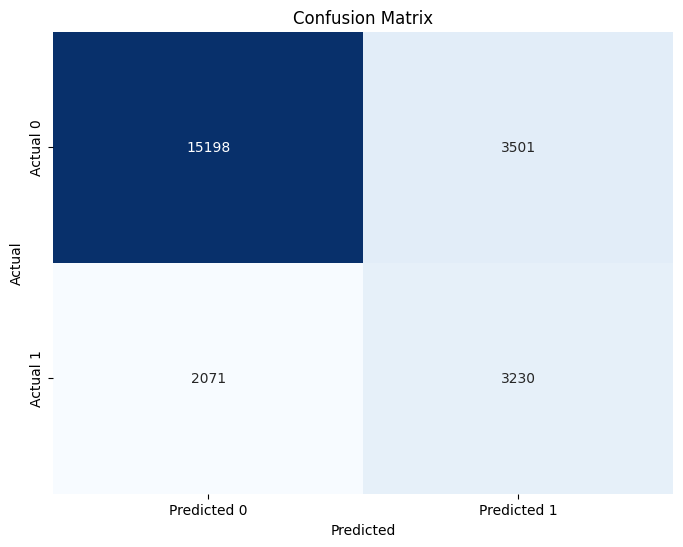

The final f1-score for the Stacking Ensemble model is: 0.5369015957446809


In [29]:
# Predict classes based on the best threshold
y_pred_stacking = (best_stacking_model.predict_proba(X_test_scaled)[:,1] >= best_threshold_stacking).astype(int)

# Create the confusion matrix
cm_stacking = confusion_matrix(y_test, y_pred_stacking)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_stacking, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate the f1 score
f1_final_stacking = f1_score(y_test, y_pred_stacking)
print(f"The final f1-score for the Stacking Ensemble model is: {f1_final_stacking}")

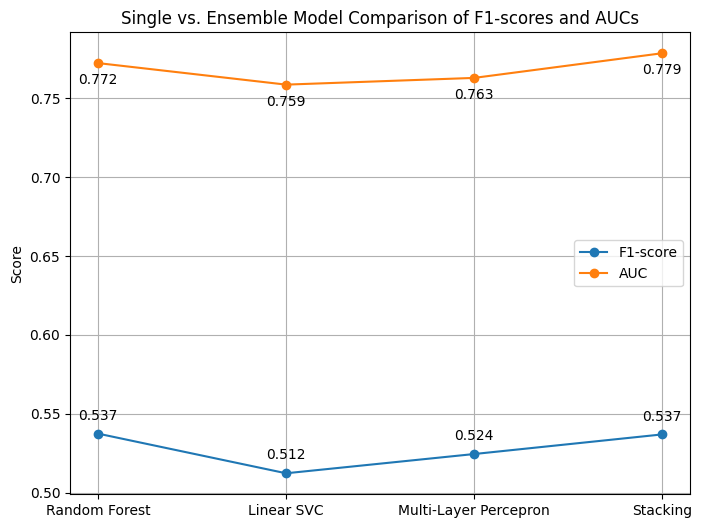

In [36]:
models = ['Random Forest', 'Linear SVC', 'Multi-Layer Percepron', 'Stacking']
f1_scores = [f1_final_rf, f1_final_lsvc, f1_final_mlp, f1_final_stacking]
aucs = [roc_auc_rf, roc_auc_lsvc, roc_auc_mlp, roc_auc_stacking]

x = range(len(models))

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, f1_scores, marker='o', label='F1-score')
plt.plot(x, aucs, marker='o', label='AUC')

# Annotate each point with its value
for i, txt in enumerate(f1_scores):
    plt.annotate(f'{txt:.3f}', (x[i], f1_scores[i]), textcoords="offset points", xytext=(0,10), ha='center')
for i, txt in enumerate(aucs):
    plt.annotate(f'{txt:.3f}', (x[i], aucs[i]), textcoords="offset points", xytext=(0,-15), ha='center')

plt.xticks(x, models)
plt.ylabel("Score")
plt.title("Single vs. Ensemble Model Comparison of F1-scores and AUCs")
plt.legend()
plt.grid(True)
plt.show()

# **Final Model Summary**

To predict whether a customer is likely to default on payments, I trained and evaluated a total of 13 individual models by separating them into 3 groups, including five tree-based models (Decision Tree, Random Forest, AdaBoost, Gradient Boosting, and XGBoost), four Support Vector Machines (linear and kernel-based), K-Nearest Neighbors (KNN), Gaussian Naive Bayes, and Multi-Layer Perceptron (MLP). Finally, I combined the best single models to experiment with stacked ensemble models. Each model was assessed based on cross-validation scores and f1 scores. The best model in each branch of models is further refined using hyperparameter tuning and threshold adjustments, before comparing the top models using the final f1 scores, AUC, and confusion matrices.

Among these, Random Forest, Linear SVC, and Multi-Layer Perceptron emerged as the top single three models. Random Forest achieved the highest f1 measure of 0.537 and AUC of 0.772, demonstrating its reliability in predicing defulat customers while optimizing the precision. MLP showed more robust performance in identifying the true positive instances but with slightly lower precision than RF.

After combining the best single models to form a stacking ensemble, I tuned its hyperparameters and threshold values. However, the improvements of the stacking ensemble from the single models are small. Since ensemble models generally require significantly more computing resources and time, I do not believe it is worth the effort to increase the computational cost to our final model.

I'd recommend Random Forest as the final model if the bank prioritizes overall reliability and interpretations of the predictions. Its high f1 score and AUC measures demonstrates the best capability to dinstinguish between classes and high reliability of the predicted true instances. It is also ideal when the future prediction data is relatively small. However, if large datasets and complex patterns are expected, then MLP provides a competitive alternative. MLP is capable of identifying more positive instances than Random Forest, even though at a cost of decreased precision. The final decision as to which model to implement stays with the bank's business stakeholders, but my dual recommendation ensures that the final model choice aligns closely with the bank's operational priorities and objectives.



# **Part 6. Feature Importance Analysis**

Determine the most important features in the random forest classifier.

               Feature  Importance
5                PAY_1    0.081557
25  PAY_1_freq_encoded    0.076069
41       AGE_LIMIT_BAL    0.039177
31    Bill_Amt_Ratio_1    0.035382
11           BILL_AMT1    0.032629
33    Bill_Amt_Ratio_3    0.032165
32    Bill_Amt_Ratio_2    0.031567
18            PAY_AMT2    0.031199
4                  AGE    0.030111
6                PAY_2    0.029981


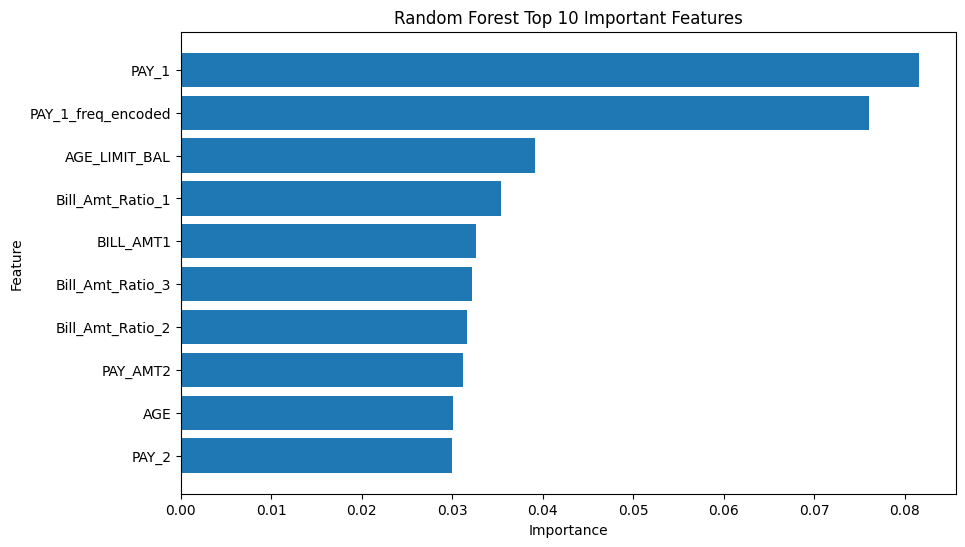

In [ ]:
best_rf = grid_search_rf.best_estimator_

# Train the model
best_rf.fit(X_train, y_train)

# Get feature importances
rf_feature_importances = best_rf.feature_importances_

# Create a DataFrame to store feature importances
feature_importance_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)

# Print or visualize the top N important features
top_n = 10
print(feature_importance_rf.head(top_n))

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_rf['Feature'][:top_n], feature_importance_rf['Importance'][:top_n])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Top {} Important Features'.format(top_n))
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

Determine the most important features in the Gradient Boosting model.

                       Feature  Importance
5                        PAY_1    0.348711
25          PAY_1_freq_encoded    0.334540
37  Consistently_Late_2_Months    0.031765
19                    PAY_AMT3    0.029035
20                    PAY_AMT4    0.029010
32            Bill_Amt_Ratio_2    0.023149
18                    PAY_AMT2    0.021216
38  Consistently_Late_3_Months    0.017198
11                   BILL_AMT1    0.015025
31            Bill_Amt_Ratio_1    0.012891


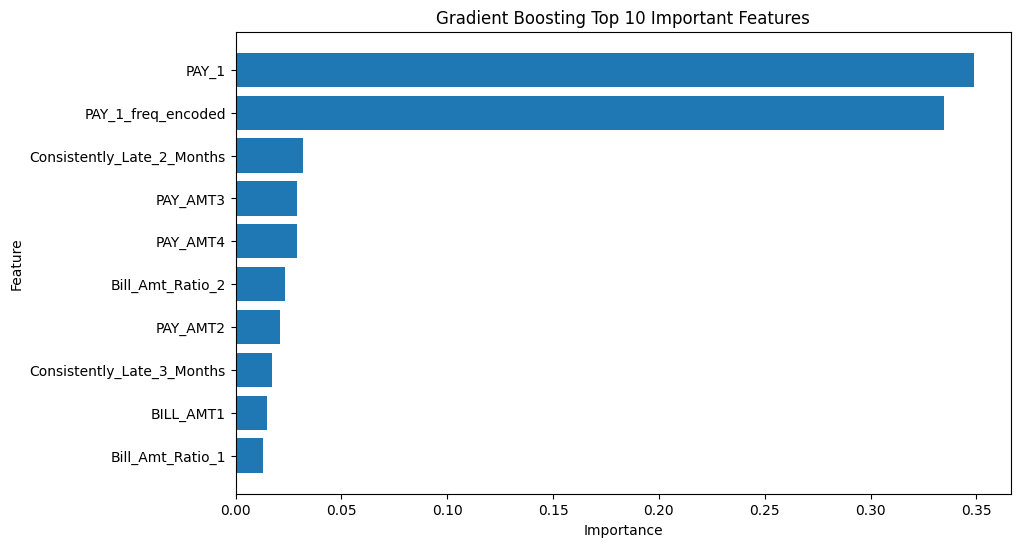

In [ ]:
best_gb = grid_search_gb.best_estimator_

# Train the model
best_gb.fit(X_train, y_train)

# Get feature importances
gb_feature_importances= best_gb.feature_importances_

# Create a DataFrame to store feature importances
feature_importance_gb = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances_gb})

# Sort the DataFrame by importance in descending order
feature_importance_gb = feature_importance_gb.sort_values(by='Importance', ascending=False)

top_n = 10
print(feature_importance_gb.head(top_n))

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_gb['Feature'][:top_n], feature_importance_gb['Importance'][:top_n])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Gradient Boosting Top {} Important Features'.format(top_n))
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

Determine the most important features in the AdaBoost model.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


               Feature  Importance
5                PAY_1        0.78
25  PAY_1_freq_encoded        0.22
1                  SEX        0.00
2            EDUCATION        0.00
3             MARRIAGE        0.00
4                  AGE        0.00
6                PAY_2        0.00
7                PAY_3        0.00
8                PAY_4        0.00
0            LIMIT_BAL        0.00


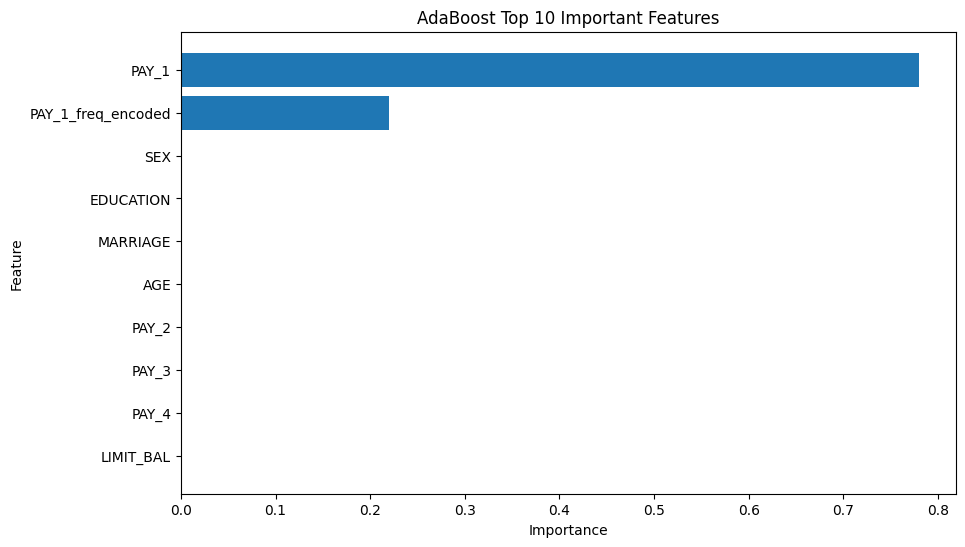

In [ ]:
best_ada = grid_search_ada.best_estimator_

# Train the model
best_ada.fit(X_train, y_train)

# Get feature importances
ada_feature_importances = best_ada.feature_importances_

# DataFrame to store feature importances
feature_importance_ada = pd.DataFrame({'Feature': X_train.columns, 'Importance': ada_feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_ada = feature_importance_ada.sort_values(by='Importance', ascending=False)

top_n=10
print(feature_importance_ada.head(top_n))

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_ada['Feature'][:top_n], feature_importance_ada['Importance'][:top_n])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('AdaBoost Top {} Important Features'.format(top_n))
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


**Partial Dependence Plots**

Plots for the most important features in the random forest model.

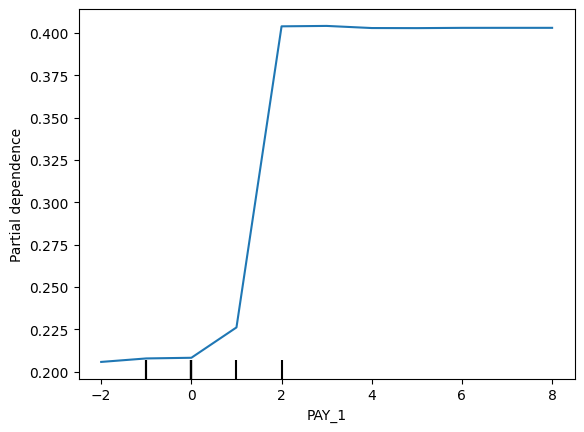

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

features = ['PAY_1']
PartialDependenceDisplay.from_estimator(best_rf, X_train, features)
plt.show()

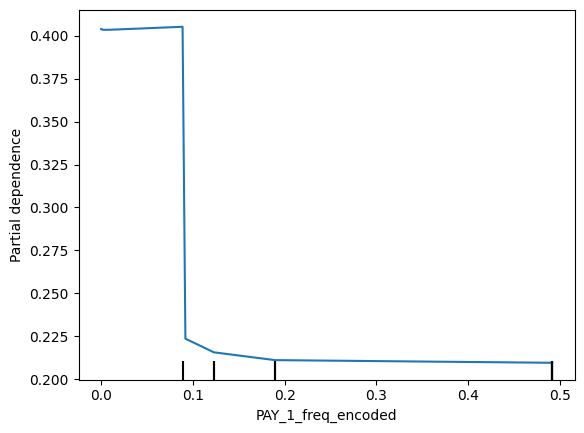

In [ ]:
features = ['PAY_1_freq_encoded']
PartialDependenceDisplay.from_estimator(best_rf, X_train, features)
plt.show()

Plots for the most important features in Gradient Boosting.

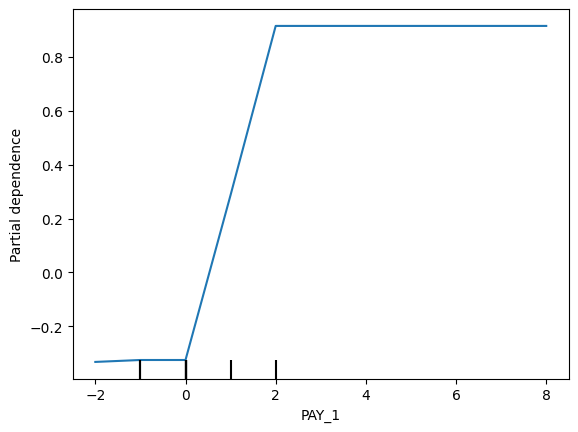

In [ ]:
features = ['PAY_1']
PartialDependenceDisplay.from_estimator(best_gb, X_train, features)
plt.show()

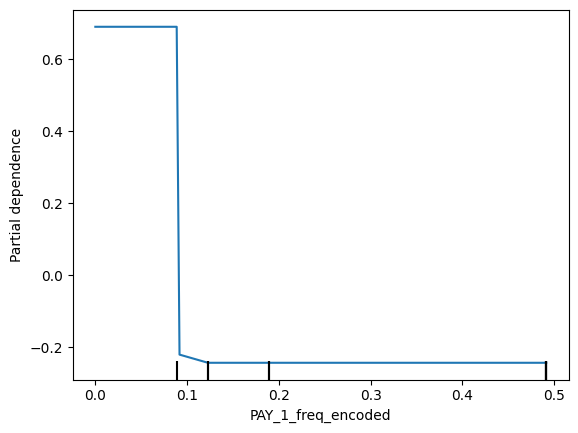

In [ ]:
features = ['PAY_1_freq_encoded']
PartialDependenceDisplay.from_estimator(best_gb, X_train, features)
plt.show()

## **Feature Importance Insights & Interpretation**




In the feature importance plots, we can identify the features that contributed the most to predicting whether a customer will default are the most recent repayment status (PAY_1) and the frequency of the recent repayment status (PAY_1_freq_encoded). The importance values of these two variables are significantly higher than all the other variables combined.

The partial dependence plots (PDPs) reaffirm the that most recent repayment status and its frequency are crucial factors in the models's predictions.

Specifically, PDPs for PAY_1 shows a clear trend: the higher the values of PAY_1, the longer the payment is delayed, and the more the predicted probability of default increases. This suggests that the customers with very recent payment delays are more likely to default.

The PDPs for PAY_1_freq_encoded demonstrates a more pronounced yet interesting trend. As the frequency increases, the probability of default goes down. But when frequency lowers, the probability of default increases rapidly. This highlights that stability is the key - when new infrequent actions emerge, they are likely to be indicators of default. This finding is intuitive as well. If we suddenly see unusual payment delays from a customer who had been diligently making the payments in the past, they must have encountered serious financial challenges. The more unusual the actions are, the more serious the problem is, and the less likely they are to recover form the setback quickly, leading to default.



## **Suggestions & Recommendations**

Based on the feature importance analysis and partial dependence plots (PDPs), the bank can use the above findings in several practical ways to minimize the risk of customer default and offer new products or programs that provide targeted assistance to customers.

1. Credit Limits and Approval Decisions: When approving new credit or loans, the bank could use similar criteria (PAY_1 and PAY_1_freq_encoded) to adjust credit limits or offer customized loan products. Customers with a history of irregular or delayed payments could be offered lower credit limits or higher collateral requirements to mitigate risk.

2. Behavioral Monitoring and Flags: Create an automated monitoring system that flags unusual payment behavior. For instance, if a customer who had been making regular payments suddenly shows infrequent or irregular payment patterns, the system should trigger a flag for further review. Banks can reach out and offer support to flagged customers as part of the proactive outreach.

3. Proactive Outreach: After implementing a system to flag unusual payment behavior and flag customers with recent payment delays (e.g., those with a high PAY_1 score), the bank can initiate early intervention programs. This could include reminders, personalized emails, or phone calls to offer support, check on the customer's financial well-being, and discuss repayment options.

4. Custom Repayment Plans: For customers showing a recent delay in payments, the bank can offer custom repayment plans that extend the term or reduce the payment amount temporarily to ease their financial burden.

5. Targeted Financial Assistance: For customers with a sudden decline in payment frequency, offer emergency relief programs or flexible repayment options. These could include offering a grace period or restructuring debt payments to avoid a default.

# **Potential Improvements**

To further improve the model performance and continue the analysis, we can consider the following strategies:

1. Data Augmentation: This dataset doesn't provide any information about customers' household income, spending habits, ownership of properties, and the existance of other checking or savings accounts. These information, although auxiliary and difficult to obtain, are pivotal to determine a person's loan repayment ability for appropriate credit setting. Collecting and analyzing additional financial data about the customers can potentially increase our model performance and offer more insights.

2. Offline and Online Data: We can decompose this dataset into offline and online components. The offline data would contain demographic data and total payment summary of the customer. The online dataset includes each payment (PAY_AMT1 to PAY_AMT5) and bill (BILL_AMT1 to BILL_AMT5) amount by every customer. From here, it would be valuable to extract individual transaction data by breaking down the payments and bills into more granular transactions. This will require data augmentation or using data distribution of a similar credit card transaction dataset. Either way, the technique to divide the dataset into two parts will create more complications for this problem, but it can help us to calculate a total risk probability where the Total Risk = Risk probability from online data + Risk probability from offline data.

3. Dimensionality Reduction: We could try exploring techniques such as Principle Component Analysis (PCA) to reduce the number of features while retaining most of the information. This can help simplify the model and potentially improve the generalization ability.

